In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.errors import InvalidArgumentError
import tensorflow as tf

# Tensorflow GPU settings
# gpu_options = tf.GPUOptions(allow_growth=True)#per_process_gpu_memory_fraction=0.5)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import preprocessing
from sklearn.utils import shuffle

from scipy import interpolate

from atlasify import atlasify
import pickle
import os

import sys
sys.path.append('../')
import plot_util
import util

In [2]:
# Note that we are loading the FULL signal and background datasets
sig = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220301_ELReLMIs54_MUReLMIs31_btag77_VVZ.arrow')
sig['is_signal'] = True
bg = pd.read_feather(('/home/grabanal/WVZ/gabriel_ML_data/'
                           + '20220301_ELReLMIs54_MUReLMIs31_btag77_FULLBG.arrow'))
bg['is_signal'] = False

In [3]:
train_feats = sorted([f for f in sig.columns if f not in ['index', 'wgt', 'is_signal', 
                                                          'v_j_btag77', 'v_j_btag60', 
                                                          'v_j_btag85', 'v_j_btagCont', 'v_j_btag70']])
print('Using the following training features:')
print(sorted(train_feats))

Using the following training features:
['HT', 'MET', 'METPhi', 'METSig', 'Njet', 'Nlep', 'SR', 'Wlep1_ambiguous', 'Wlep1_dphi', 'Wlep1_eta', 'Wlep1_phi', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_ambiguous', 'Wlep2_dphi', 'Wlep2_eta', 'Wlep2_phi', 'Wlep2_pid', 'Wlep2_pt', 'Zcand_mass', 'Zlep1_ambiguous', 'Zlep1_dphi', 'Zlep1_eta', 'Zlep1_phi', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_ambiguous', 'Zlep2_dphi', 'Zlep2_eta', 'Zlep2_phi', 'Zlep2_pid', 'Zlep2_pt', 'chisq', 'eta_1', 'eta_2', 'eta_3', 'eta_4', 'jet_btagCont_1', 'jet_btagCont_2', 'jet_btagCont_3', 'jet_btagCont_4', 'jet_eta_1', 'jet_eta_2', 'jet_eta_3', 'jet_eta_4', 'jet_m_1', 'jet_m_2', 'jet_m_3', 'jet_m_4', 'jet_phi_1', 'jet_phi_2', 'jet_phi_3', 'jet_phi_4', 'jet_pt_1', 'jet_pt_2', 'jet_pt_3', 'jet_pt_4', 'lep1_ambiguous', 'lep1_pid', 'lep2_ambiguous', 'lep2_pid', 'lep3_ambiguous', 'lep3_pid', 'lep4_ambiguous', 'lep4_pid', 'leptonic_HT', 'mass_4l', 'other_mass', 'phi_1', 'phi_2', 'phi_3', 'phi_4', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l', 'tota

In [4]:
# Normalize training features
X = pd.concat([sig[train_feats], bg[train_feats]], ignore_index=True)

min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler.fit(X)

for df in [sig, bg]:
    df[train_feats] = min_max_scaler.transform(df[train_feats])

In [5]:
# Cut to 4l-DF signal region
bg = bg[bg.SR == 1]
sig = sig[sig.SR == 1]

# Setup k-folds

In [40]:
combined_data = pd.concat([sig[train_feats + ['wgt', 'is_signal']], bg[train_feats + ['wgt', 'is_signal']]], 
                          ignore_index=True)
combined_labels = np.concatenate([np.ones(len(sig)), np.zeros(len(bg))])

In [41]:
K_FOLDS = 5
k_folder = StratifiedKFold(n_splits = K_FOLDS, random_state=314, shuffle=True)

# Assign k-folds
combined_data['k_fold'] = -1
for i, (_, test_index) in enumerate(k_folder.split(combined_data, combined_labels)):
    combined_data.loc[test_index, 'k_fold'] = i

# Train models

In [ ]:
EPOCHS = 10000
PATIENCE = 200
BATCH_SIZE = 128
NUM_NODES = 64
DROPOUT = 0.1
LEARN_RATE = 1e-5

def make_model(input_dim, num_nodes, dropout, learn_rate):
    # Generate and fit model
    K.clear_session()
    classifier = Sequential()
    classifier.add(Dense(num_nodes, input_dim=input_dim, activation='relu')) 
    classifier.add(Dropout(dropout))
    classifier.add(Dense(num_nodes, activation='relu'))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(num_nodes, activation='relu'))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(1, activation='sigmoid'))

    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    classifier.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return classifier

models = [None] * K_FOLDS

for k in range(K_FOLDS):
    # Generate train and validation samples
    # The test sample has k-index k
    # The validation sample has k-index k - 1
    # The rest is for training
    val_k_index = k - 1
    if val_k_index < 0:
        val_k_index = K_FOLDS - 1
        
    x_val = combined_data[combined_data.k_fold == val_k_index]
    y_val = combined_labels[combined_data.k_fold == val_k_index]
    w_val = np.abs(x_val.wgt)
    
    x_train = combined_data[(combined_data.k_fold != k)&(combined_data.k_fold != val_k_index)]
    y_train = combined_labels[(combined_data.k_fold != k)&(combined_data.k_fold != val_k_index)]
    
    n_train_sig = sum(x_train[y_train == 1].wgt)
    n_train_bg = sum(x_train[y_train == 0].wgt)
    
    sig_correction = (n_train_sig + n_train_bg) / (2 * n_train_sig)
    bg_correction = (n_train_sig + n_train_bg) / (2 * n_train_bg)
    w_train = (sig_correction * y_train + bg_correction * (1 - y_train)) * np.abs(x_train.wgt)
    
    # Restrict to training features
    x_train = x_train[train_feats]
    x_val = x_val[train_feats]
    
    # Generate and fit model
    classifier = make_model(input_dim=x_train.shape[1], num_nodes=NUM_NODES, 
                            dropout=DROPOUT, learn_rate=LEARN_RATE)
    
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, 
                                                   restore_best_weights=True)

    history = classifier.fit(x_train, y_train, sample_weight=w_train, 
                             validation_data=(x_val, y_val, w_val),
                             epochs=EPOCHS, batch_size=BATCH_SIZE,
                             verbose=1, callbacks=[es_callback], shuffle=True)
    
    # Save model and history
    model_dir = 'models/SR_DF/'
    model_name = 'classifier_abs_wgt_k_' + str(k)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        
    classifier.save(model_dir + model_name)
    with open(model_dir + model_name + '_history.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

Epoch 1/10000
261/261 [==============================] - 2s 4ms/step - loss: 0.0012 - accuracy: 0.6006 - val_loss: 0.0013 - val_accuracy: 0.6390
Epoch 2/10000
261/261 [==============================] - 1s 4ms/step - loss: 0.0012 - accuracy: 0.6204 - val_loss: 0.0012 - val_accuracy: 0.6494
Epoch 3/10000
261/261 [==============================] - 1s 4ms/step - loss: 0.0012 - accuracy: 0.6436 - val_loss: 0.0012 - val_accuracy: 0.6529
Epoch 4/10000
261/261 [==============================] - 1s 4ms/step - loss: 0.0012 - accuracy: 0.6461 - val_loss: 0.0012 - val_accuracy: 0.6535
Epoch 5/10000
261/261 [==============================] - 1s 4ms/step - loss: 0.0012 - accuracy: 0.6503 - val_loss: 0.0012 - val_accuracy: 0.6540
Epoch 6/10000
261/261 [==============================] - 1s 4ms/step - loss: 0.0012 - accuracy: 0.6538 - val_loss: 0.0012 - val_accuracy: 0.6540
Epoch 7/10000
261/261 [==============================] - 1s 4ms/step - loss: 0.0012 - accuracy: 0.6572 - val_loss: 0.0011 - val_ac

261/261 [==============================] - 1s 4ms/step - loss: 0.0010 - accuracy: 0.6638 - val_loss: 9.9322e-04 - val_accuracy: 0.6770
Epoch 114/10000
261/261 [==============================] - 1s 4ms/step - loss: 0.0010 - accuracy: 0.6657 - val_loss: 9.9239e-04 - val_accuracy: 0.6779
Epoch 115/10000
261/261 [==============================] - 1s 4ms/step - loss: 0.0011 - accuracy: 0.6658 - val_loss: 9.8747e-04 - val_accuracy: 0.6781
Epoch 116/10000
261/261 [==============================] - 1s 4ms/step - loss: 0.0010 - accuracy: 0.6628 - val_loss: 9.9010e-04 - val_accuracy: 0.6787
Epoch 117/10000
261/261 [==============================] - 1s 4ms/step - loss: 0.0011 - accuracy: 0.6640 - val_loss: 9.9036e-04 - val_accuracy: 0.6793
Epoch 118/10000
261/261 [==============================] - 1s 4ms/step - loss: 0.0010 - accuracy: 0.6676 - val_loss: 9.8994e-04 - val_accuracy: 0.6800
Epoch 119/10000
261/261 [==============================] - 1s 4ms/step - loss: 0.0011 - accuracy: 0.6648 - val

261/261 [==============================] - 1s 4ms/step - loss: 9.8700e-04 - accuracy: 0.6804 - val_loss: 9.3588e-04 - val_accuracy: 0.6974
Epoch 168/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.8249e-04 - accuracy: 0.6832 - val_loss: 9.3164e-04 - val_accuracy: 0.6979
Epoch 169/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.7417e-04 - accuracy: 0.6771 - val_loss: 9.3109e-04 - val_accuracy: 0.6978
Epoch 170/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.8483e-04 - accuracy: 0.6794 - val_loss: 9.1687e-04 - val_accuracy: 0.6994
Epoch 171/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.7374e-04 - accuracy: 0.6850 - val_loss: 9.2489e-04 - val_accuracy: 0.6982
Epoch 172/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.8965e-04 - accuracy: 0.6858 - val_loss: 9.2414e-04 - val_accuracy: 0.6986
Epoch 173/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.7849e

Epoch 220/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.3363e-04 - accuracy: 0.6950 - val_loss: 8.8433e-04 - val_accuracy: 0.7084
Epoch 221/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.4601e-04 - accuracy: 0.6944 - val_loss: 8.8553e-04 - val_accuracy: 0.7093
Epoch 222/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.5843e-04 - accuracy: 0.6970 - val_loss: 8.8609e-04 - val_accuracy: 0.7097
Epoch 223/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.4387e-04 - accuracy: 0.6908 - val_loss: 8.8858e-04 - val_accuracy: 0.7096
Epoch 224/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.3017e-04 - accuracy: 0.6911 - val_loss: 8.8185e-04 - val_accuracy: 0.7097
Epoch 225/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.3802e-04 - accuracy: 0.6960 - val_loss: 8.8755e-04 - val_accuracy: 0.7098
Epoch 226/10000
261/261 [==============================] - 1s 4ms/step

Epoch 273/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.4572e-04 - accuracy: 0.7019 - val_loss: 8.6139e-04 - val_accuracy: 0.7150
Epoch 274/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.8907e-04 - accuracy: 0.7003 - val_loss: 8.7567e-04 - val_accuracy: 0.7151
Epoch 275/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.1752e-04 - accuracy: 0.7012 - val_loss: 8.6541e-04 - val_accuracy: 0.7155
Epoch 276/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.1977e-04 - accuracy: 0.7038 - val_loss: 8.7367e-04 - val_accuracy: 0.7148
Epoch 277/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.0323e-04 - accuracy: 0.7001 - val_loss: 8.7104e-04 - val_accuracy: 0.7147
Epoch 278/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.2061e-04 - accuracy: 0.7037 - val_loss: 8.7436e-04 - val_accuracy: 0.7157
Epoch 279/10000
261/261 [==============================] - 1s 5ms/step

Epoch 326/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.9001e-04 - accuracy: 0.7100 - val_loss: 8.5639e-04 - val_accuracy: 0.7196
Epoch 327/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8451e-04 - accuracy: 0.7116 - val_loss: 8.6925e-04 - val_accuracy: 0.7188
Epoch 328/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.0054e-04 - accuracy: 0.7063 - val_loss: 8.5127e-04 - val_accuracy: 0.7201
Epoch 329/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.0408e-04 - accuracy: 0.7088 - val_loss: 8.4474e-04 - val_accuracy: 0.7215
Epoch 330/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.9131e-04 - accuracy: 0.7105 - val_loss: 8.4670e-04 - val_accuracy: 0.7214
Epoch 331/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.9124e-04 - accuracy: 0.7122 - val_loss: 8.5310e-04 - val_accuracy: 0.7212
Epoch 332/10000
261/261 [==============================] - 1s 5ms/step

Epoch 379/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.9238e-04 - accuracy: 0.7118 - val_loss: 8.3396e-04 - val_accuracy: 0.7246
Epoch 380/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.7458e-04 - accuracy: 0.7146 - val_loss: 8.3896e-04 - val_accuracy: 0.7242
Epoch 381/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8551e-04 - accuracy: 0.7136 - val_loss: 8.3605e-04 - val_accuracy: 0.7243
Epoch 382/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8303e-04 - accuracy: 0.7146 - val_loss: 8.3293e-04 - val_accuracy: 0.7250
Epoch 383/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.6643e-04 - accuracy: 0.7179 - val_loss: 8.4497e-04 - val_accuracy: 0.7233
Epoch 384/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.7712e-04 - accuracy: 0.7152 - val_loss: 8.3305e-04 - val_accuracy: 0.7248
Epoch 385/10000
261/261 [==============================] - 1s 5ms/step

Epoch 432/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.7231e-04 - accuracy: 0.7151 - val_loss: 8.3355e-04 - val_accuracy: 0.7256
Epoch 433/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.6092e-04 - accuracy: 0.7225 - val_loss: 8.2467e-04 - val_accuracy: 0.7265
Epoch 434/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5325e-04 - accuracy: 0.7196 - val_loss: 8.3227e-04 - val_accuracy: 0.7256
Epoch 435/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.6794e-04 - accuracy: 0.7148 - val_loss: 8.2728e-04 - val_accuracy: 0.7259
Epoch 436/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5309e-04 - accuracy: 0.7210 - val_loss: 8.3419e-04 - val_accuracy: 0.7254
Epoch 437/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5059e-04 - accuracy: 0.7178 - val_loss: 8.2510e-04 - val_accuracy: 0.7266
Epoch 438/10000
261/261 [==============================] - 1s 5ms/step

Epoch 485/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.6057e-04 - accuracy: 0.7222 - val_loss: 8.2352e-04 - val_accuracy: 0.7263
Epoch 486/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.7125e-04 - accuracy: 0.7175 - val_loss: 8.2350e-04 - val_accuracy: 0.7269
Epoch 487/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5139e-04 - accuracy: 0.7191 - val_loss: 8.1588e-04 - val_accuracy: 0.7269
Epoch 488/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.6181e-04 - accuracy: 0.7194 - val_loss: 8.3055e-04 - val_accuracy: 0.7264
Epoch 489/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5766e-04 - accuracy: 0.7188 - val_loss: 8.3349e-04 - val_accuracy: 0.7268
Epoch 490/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3915e-04 - accuracy: 0.7224 - val_loss: 8.3458e-04 - val_accuracy: 0.7268
Epoch 491/10000
261/261 [==============================] - 1s 5ms/step

Epoch 538/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4229e-04 - accuracy: 0.7241 - val_loss: 8.1906e-04 - val_accuracy: 0.7287
Epoch 539/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2656e-04 - accuracy: 0.7205 - val_loss: 8.1364e-04 - val_accuracy: 0.7290
Epoch 540/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3453e-04 - accuracy: 0.7194 - val_loss: 8.2169e-04 - val_accuracy: 0.7286
Epoch 541/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3682e-04 - accuracy: 0.7225 - val_loss: 8.2305e-04 - val_accuracy: 0.7288
Epoch 542/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3752e-04 - accuracy: 0.7230 - val_loss: 8.3472e-04 - val_accuracy: 0.7272
Epoch 543/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5264e-04 - accuracy: 0.7212 - val_loss: 8.2478e-04 - val_accuracy: 0.7285
Epoch 544/10000
261/261 [==============================] - 1s 5ms/step

Epoch 591/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.2797e-04 - accuracy: 0.7220 - val_loss: 8.1432e-04 - val_accuracy: 0.7276
Epoch 592/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3688e-04 - accuracy: 0.7248 - val_loss: 8.1103e-04 - val_accuracy: 0.7283
Epoch 593/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2784e-04 - accuracy: 0.7245 - val_loss: 8.0498e-04 - val_accuracy: 0.7285
Epoch 594/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2984e-04 - accuracy: 0.7278 - val_loss: 8.0055e-04 - val_accuracy: 0.7291
Epoch 595/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1984e-04 - accuracy: 0.7304 - val_loss: 8.1670e-04 - val_accuracy: 0.7275
Epoch 596/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1728e-04 - accuracy: 0.7264 - val_loss: 8.1639e-04 - val_accuracy: 0.7276
Epoch 597/10000
261/261 [==============================] - 1s 5ms/step

Epoch 644/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4027e-04 - accuracy: 0.7219 - val_loss: 8.0771e-04 - val_accuracy: 0.7293
Epoch 645/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1436e-04 - accuracy: 0.7279 - val_loss: 7.9943e-04 - val_accuracy: 0.7294
Epoch 646/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2288e-04 - accuracy: 0.7249 - val_loss: 8.1227e-04 - val_accuracy: 0.7280
Epoch 647/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2257e-04 - accuracy: 0.7286 - val_loss: 8.1626e-04 - val_accuracy: 0.7274
Epoch 648/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1398e-04 - accuracy: 0.7236 - val_loss: 8.1290e-04 - val_accuracy: 0.7281
Epoch 649/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3511e-04 - accuracy: 0.7296 - val_loss: 8.0379e-04 - val_accuracy: 0.7287
Epoch 650/10000
261/261 [==============================] - 1s 5ms/step

Epoch 697/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2909e-04 - accuracy: 0.7279 - val_loss: 7.9966e-04 - val_accuracy: 0.7300
Epoch 698/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1465e-04 - accuracy: 0.7250 - val_loss: 7.9445e-04 - val_accuracy: 0.7301
Epoch 699/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0351e-04 - accuracy: 0.7294 - val_loss: 8.0667e-04 - val_accuracy: 0.7314
Epoch 700/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2543e-04 - accuracy: 0.7228 - val_loss: 8.0440e-04 - val_accuracy: 0.7314
Epoch 701/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1516e-04 - accuracy: 0.7313 - val_loss: 8.0104e-04 - val_accuracy: 0.7310
Epoch 702/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0236e-04 - accuracy: 0.7320 - val_loss: 8.0396e-04 - val_accuracy: 0.7309
Epoch 703/10000
261/261 [==============================] - 1s 5ms/step

Epoch 750/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.9749e-04 - accuracy: 0.7300 - val_loss: 7.9956e-04 - val_accuracy: 0.7325
Epoch 751/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0860e-04 - accuracy: 0.7295 - val_loss: 7.9675e-04 - val_accuracy: 0.7322
Epoch 752/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0078e-04 - accuracy: 0.7265 - val_loss: 8.0590e-04 - val_accuracy: 0.7324
Epoch 753/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0490e-04 - accuracy: 0.7293 - val_loss: 8.0459e-04 - val_accuracy: 0.7319
Epoch 754/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8452e-04 - accuracy: 0.7291 - val_loss: 8.0899e-04 - val_accuracy: 0.7320
Epoch 755/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.9848e-04 - accuracy: 0.7310 - val_loss: 7.9850e-04 - val_accuracy: 0.7319
Epoch 756/10000
261/261 [==============================] - 1s 5ms/step

Epoch 803/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.9985e-04 - accuracy: 0.7283 - val_loss: 7.9662e-04 - val_accuracy: 0.7350
Epoch 804/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0710e-04 - accuracy: 0.7283 - val_loss: 7.8762e-04 - val_accuracy: 0.7347
Epoch 805/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.9490e-04 - accuracy: 0.7260 - val_loss: 8.0230e-04 - val_accuracy: 0.7348
Epoch 806/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.9663e-04 - accuracy: 0.7243 - val_loss: 7.8315e-04 - val_accuracy: 0.7349
Epoch 807/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0178e-04 - accuracy: 0.7344 - val_loss: 7.8941e-04 - val_accuracy: 0.7346
Epoch 808/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0684e-04 - accuracy: 0.7301 - val_loss: 7.9333e-04 - val_accuracy: 0.7350
Epoch 809/10000
261/261 [==============================] - 1s 5ms/step

Epoch 856/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8717e-04 - accuracy: 0.7362 - val_loss: 7.8770e-04 - val_accuracy: 0.7353
Epoch 857/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.9231e-04 - accuracy: 0.7347 - val_loss: 7.8921e-04 - val_accuracy: 0.7352
Epoch 858/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7573e-04 - accuracy: 0.7348 - val_loss: 7.9133e-04 - val_accuracy: 0.7357
Epoch 859/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8803e-04 - accuracy: 0.7288 - val_loss: 7.7553e-04 - val_accuracy: 0.7371
Epoch 860/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8402e-04 - accuracy: 0.7270 - val_loss: 7.7610e-04 - val_accuracy: 0.7367
Epoch 861/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.9444e-04 - accuracy: 0.7320 - val_loss: 7.8945e-04 - val_accuracy: 0.7357
Epoch 862/10000
261/261 [==============================] - 1s 5ms/step

Epoch 909/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7525e-04 - accuracy: 0.7332 - val_loss: 7.9182e-04 - val_accuracy: 0.7369
Epoch 910/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.9263e-04 - accuracy: 0.7315 - val_loss: 7.8490e-04 - val_accuracy: 0.7368
Epoch 911/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7614e-04 - accuracy: 0.7355 - val_loss: 7.9736e-04 - val_accuracy: 0.7372
Epoch 912/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.9092e-04 - accuracy: 0.7297 - val_loss: 7.7893e-04 - val_accuracy: 0.7372
Epoch 913/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7575e-04 - accuracy: 0.7386 - val_loss: 7.9459e-04 - val_accuracy: 0.7371
Epoch 914/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8171e-04 - accuracy: 0.7310 - val_loss: 7.9325e-04 - val_accuracy: 0.7371
Epoch 915/10000
261/261 [==============================] - 1s 5ms/step

Epoch 962/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7106e-04 - accuracy: 0.7345 - val_loss: 7.8934e-04 - val_accuracy: 0.7373
Epoch 963/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8110e-04 - accuracy: 0.7345 - val_loss: 7.8413e-04 - val_accuracy: 0.7378
Epoch 964/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.9368e-04 - accuracy: 0.7280 - val_loss: 7.8702e-04 - val_accuracy: 0.7374
Epoch 965/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7785e-04 - accuracy: 0.7382 - val_loss: 7.7066e-04 - val_accuracy: 0.7380
Epoch 966/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7668e-04 - accuracy: 0.7320 - val_loss: 7.7902e-04 - val_accuracy: 0.7372
Epoch 967/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.6687e-04 - accuracy: 0.7349 - val_loss: 7.8438e-04 - val_accuracy: 0.7378
Epoch 968/10000
261/261 [==============================] - 1s 5ms/step

Epoch 1015/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.6655e-04 - accuracy: 0.7367 - val_loss: 7.8494e-04 - val_accuracy: 0.7375
Epoch 1016/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8017e-04 - accuracy: 0.7364 - val_loss: 7.9546e-04 - val_accuracy: 0.7386
Epoch 1017/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5616e-04 - accuracy: 0.7371 - val_loss: 7.8425e-04 - val_accuracy: 0.7381
Epoch 1018/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.6099e-04 - accuracy: 0.7377 - val_loss: 7.8792e-04 - val_accuracy: 0.7383
Epoch 1019/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7522e-04 - accuracy: 0.7327 - val_loss: 7.7337e-04 - val_accuracy: 0.7384
Epoch 1020/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5507e-04 - accuracy: 0.7363 - val_loss: 7.8920e-04 - val_accuracy: 0.7383
Epoch 1021/10000
261/261 [==============================] - 1s 5

261/261 [==============================] - 1s 5ms/step - loss: 7.4293e-04 - accuracy: 0.7294 - val_loss: 7.8272e-04 - val_accuracy: 0.7393
Epoch 1120/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.6047e-04 - accuracy: 0.7388 - val_loss: 7.6848e-04 - val_accuracy: 0.7396
Epoch 1121/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7172e-04 - accuracy: 0.7381 - val_loss: 7.7124e-04 - val_accuracy: 0.7393
Epoch 1122/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5429e-04 - accuracy: 0.7351 - val_loss: 7.7093e-04 - val_accuracy: 0.7396
Epoch 1123/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7931e-04 - accuracy: 0.7327 - val_loss: 7.7567e-04 - val_accuracy: 0.7395
Epoch 1124/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5651e-04 - accuracy: 0.7390 - val_loss: 7.7467e-04 - val_accuracy: 0.7397
Epoch 1125/10000
261/261 [==============================] - 1s 5ms/step - loss: 7

261/261 [==============================] - 1s 5ms/step - loss: 7.3805e-04 - accuracy: 0.7437 - val_loss: 7.7673e-04 - val_accuracy: 0.7405
Epoch 1224/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5374e-04 - accuracy: 0.7421 - val_loss: 7.6519e-04 - val_accuracy: 0.7403
Epoch 1225/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.4201e-04 - accuracy: 0.7410 - val_loss: 7.7072e-04 - val_accuracy: 0.7404
Epoch 1226/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.3745e-04 - accuracy: 0.7437 - val_loss: 7.7491e-04 - val_accuracy: 0.7411
Epoch 1227/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5324e-04 - accuracy: 0.7402 - val_loss: 7.7259e-04 - val_accuracy: 0.7404
Epoch 1228/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.4486e-04 - accuracy: 0.7414 - val_loss: 7.6261e-04 - val_accuracy: 0.7396
Epoch 1229/10000
261/261 [==============================] - 1s 5ms/step - loss: 7

261/261 [==============================] - 1s 5ms/step - loss: 7.3448e-04 - accuracy: 0.7449 - val_loss: 7.7420e-04 - val_accuracy: 0.7419
Epoch 1328/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5721e-04 - accuracy: 0.7359 - val_loss: 7.6490e-04 - val_accuracy: 0.7419
Epoch 1329/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5121e-04 - accuracy: 0.7421 - val_loss: 7.7605e-04 - val_accuracy: 0.7418
Epoch 1330/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.4510e-04 - accuracy: 0.7419 - val_loss: 7.7506e-04 - val_accuracy: 0.7414
Epoch 1331/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.4111e-04 - accuracy: 0.7413 - val_loss: 7.7364e-04 - val_accuracy: 0.7416
Epoch 1332/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.3893e-04 - accuracy: 0.7426 - val_loss: 7.7743e-04 - val_accuracy: 0.7413
Epoch 1333/10000
261/261 [==============================] - 1s 5ms/step - loss: 7

261/261 [==============================] - 1s 5ms/step - loss: 7.2132e-04 - accuracy: 0.7472 - val_loss: 7.7543e-04 - val_accuracy: 0.7414
Epoch 1432/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.3699e-04 - accuracy: 0.7376 - val_loss: 7.6763e-04 - val_accuracy: 0.7421
Epoch 1433/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.3162e-04 - accuracy: 0.7409 - val_loss: 7.6485e-04 - val_accuracy: 0.7423
Epoch 1434/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.3413e-04 - accuracy: 0.7469 - val_loss: 7.7004e-04 - val_accuracy: 0.7418
Epoch 1435/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.1927e-04 - accuracy: 0.7457 - val_loss: 7.7000e-04 - val_accuracy: 0.7415
Epoch 1436/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.2767e-04 - accuracy: 0.7438 - val_loss: 7.7645e-04 - val_accuracy: 0.7412
Epoch 1437/10000
261/261 [==============================] - 1s 5ms/step - loss: 7

261/261 [==============================] - 1s 5ms/step - loss: 7.0653e-04 - accuracy: 0.7510 - val_loss: 7.6999e-04 - val_accuracy: 0.7430
Epoch 1536/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.1714e-04 - accuracy: 0.7458 - val_loss: 7.6848e-04 - val_accuracy: 0.7432
Epoch 1537/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.2628e-04 - accuracy: 0.7490 - val_loss: 7.7481e-04 - val_accuracy: 0.7420
Epoch 1538/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.2446e-04 - accuracy: 0.7428 - val_loss: 7.6966e-04 - val_accuracy: 0.7430
Epoch 1539/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.2269e-04 - accuracy: 0.7453 - val_loss: 7.7152e-04 - val_accuracy: 0.7432
Epoch 1540/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.3024e-04 - accuracy: 0.7446 - val_loss: 7.6606e-04 - val_accuracy: 0.7443
Epoch 1541/10000
261/261 [==============================] - 1s 5ms/step - loss: 7

Epoch 41/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.6517 - val_loss: 0.0012 - val_accuracy: 0.6551
Epoch 42/10000
261/261 [==============================] - 1s 4ms/step - loss: 0.0011 - accuracy: 0.6477 - val_loss: 0.0012 - val_accuracy: 0.6542
Epoch 43/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.6466 - val_loss: 0.0012 - val_accuracy: 0.6541
Epoch 44/10000
261/261 [==============================] - 1s 4ms/step - loss: 0.0012 - accuracy: 0.6481 - val_loss: 0.0012 - val_accuracy: 0.6544
Epoch 45/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 0.6503 - val_loss: 0.0012 - val_accuracy: 0.6547
Epoch 46/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.6493 - val_loss: 0.0012 - val_accuracy: 0.6540
Epoch 47/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 0.6452 - val_loss: 0.0012 -

Epoch 153/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.9042e-04 - accuracy: 0.6775 - val_loss: 0.0010 - val_accuracy: 0.6933
Epoch 154/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.9993e-04 - accuracy: 0.6772 - val_loss: 0.0010 - val_accuracy: 0.6937
Epoch 155/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.7986e-04 - accuracy: 0.6820 - val_loss: 0.0010 - val_accuracy: 0.6935
Epoch 156/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0010 - accuracy: 0.6804 - val_loss: 0.0010 - val_accuracy: 0.6936
Epoch 157/10000
261/261 [==============================] - 1s 4ms/step - loss: 0.0010 - accuracy: 0.6749 - val_loss: 0.0010 - val_accuracy: 0.6945
Epoch 158/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.9223e-04 - accuracy: 0.6807 - val_loss: 0.0010 - val_accuracy: 0.6939
Epoch 159/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0010 - accuracy: 0.68

Epoch 259/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.3299e-04 - accuracy: 0.7009 - val_loss: 9.3527e-04 - val_accuracy: 0.7106
Epoch 260/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.2265e-04 - accuracy: 0.7114 - val_loss: 9.3538e-04 - val_accuracy: 0.7101
Epoch 261/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.2155e-04 - accuracy: 0.6980 - val_loss: 9.3764e-04 - val_accuracy: 0.7105
Epoch 262/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.2786e-04 - accuracy: 0.6982 - val_loss: 9.2937e-04 - val_accuracy: 0.7109
Epoch 263/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.2633e-04 - accuracy: 0.7004 - val_loss: 9.5569e-04 - val_accuracy: 0.7094
Epoch 264/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.2600e-04 - accuracy: 0.7057 - val_loss: 9.4794e-04 - val_accuracy: 0.7097
Epoch 265/10000
261/261 [==============================] - 1s 5ms/step

Epoch 312/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.1224e-04 - accuracy: 0.7044 - val_loss: 9.2329e-04 - val_accuracy: 0.7145
Epoch 313/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.1244e-04 - accuracy: 0.7063 - val_loss: 9.3348e-04 - val_accuracy: 0.7143
Epoch 314/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.0985e-04 - accuracy: 0.7065 - val_loss: 9.1407e-04 - val_accuracy: 0.7145
Epoch 315/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.1584e-04 - accuracy: 0.7047 - val_loss: 9.1284e-04 - val_accuracy: 0.7147
Epoch 316/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.2724e-04 - accuracy: 0.7068 - val_loss: 9.1431e-04 - val_accuracy: 0.7147
Epoch 317/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.0001e-04 - accuracy: 0.7105 - val_loss: 9.0350e-04 - val_accuracy: 0.7154
Epoch 318/10000
261/261 [==============================] - 1s 5ms/step

Epoch 365/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.9839e-04 - accuracy: 0.7103 - val_loss: 9.0088e-04 - val_accuracy: 0.7157
Epoch 366/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.0531e-04 - accuracy: 0.7101 - val_loss: 8.9671e-04 - val_accuracy: 0.7163
Epoch 367/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.0048e-04 - accuracy: 0.7131 - val_loss: 9.0098e-04 - val_accuracy: 0.7167
Epoch 368/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.9178e-04 - accuracy: 0.7097 - val_loss: 9.0028e-04 - val_accuracy: 0.7163
Epoch 369/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.0634e-04 - accuracy: 0.7069 - val_loss: 9.0361e-04 - val_accuracy: 0.7157
Epoch 370/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.7330e-04 - accuracy: 0.7138 - val_loss: 9.0514e-04 - val_accuracy: 0.7154
Epoch 371/10000
261/261 [==============================] - 1s 5ms/step

Epoch 418/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.8624e-04 - accuracy: 0.7105 - val_loss: 8.8848e-04 - val_accuracy: 0.7157
Epoch 419/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.7021e-04 - accuracy: 0.7128 - val_loss: 8.9170e-04 - val_accuracy: 0.7154
Epoch 420/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.8452e-04 - accuracy: 0.7153 - val_loss: 8.9212e-04 - val_accuracy: 0.7154
Epoch 421/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.7434e-04 - accuracy: 0.7204 - val_loss: 8.9250e-04 - val_accuracy: 0.7161
Epoch 422/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.7196e-04 - accuracy: 0.7148 - val_loss: 8.8338e-04 - val_accuracy: 0.7182
Epoch 423/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.7547e-04 - accuracy: 0.7149 - val_loss: 8.8830e-04 - val_accuracy: 0.7167
Epoch 424/10000
261/261 [==============================] - 1s 5ms/step

Epoch 471/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.7174e-04 - accuracy: 0.7195 - val_loss: 8.8648e-04 - val_accuracy: 0.7169
Epoch 472/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.6866e-04 - accuracy: 0.7180 - val_loss: 8.7354e-04 - val_accuracy: 0.7180
Epoch 473/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.6693e-04 - accuracy: 0.7224 - val_loss: 8.8044e-04 - val_accuracy: 0.7169
Epoch 474/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.7863e-04 - accuracy: 0.7229 - val_loss: 8.8236e-04 - val_accuracy: 0.7171
Epoch 475/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8838e-04 - accuracy: 0.7143 - val_loss: 8.7389e-04 - val_accuracy: 0.7181
Epoch 476/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5511e-04 - accuracy: 0.7204 - val_loss: 8.6864e-04 - val_accuracy: 0.7190
Epoch 477/10000
261/261 [==============================] - 1s 5ms/step

Epoch 524/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5814e-04 - accuracy: 0.7143 - val_loss: 8.6154e-04 - val_accuracy: 0.7192
Epoch 525/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.6707e-04 - accuracy: 0.7165 - val_loss: 8.6026e-04 - val_accuracy: 0.7194
Epoch 526/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5338e-04 - accuracy: 0.7165 - val_loss: 8.6348e-04 - val_accuracy: 0.7194
Epoch 527/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.6216e-04 - accuracy: 0.7184 - val_loss: 8.6743e-04 - val_accuracy: 0.7191
Epoch 528/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5802e-04 - accuracy: 0.7216 - val_loss: 8.7765e-04 - val_accuracy: 0.7180
Epoch 529/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5588e-04 - accuracy: 0.7182 - val_loss: 8.7012e-04 - val_accuracy: 0.7188
Epoch 530/10000
261/261 [==============================] - 1s 5ms/step

Epoch 577/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.2319e-04 - accuracy: 0.7208 - val_loss: 8.7483e-04 - val_accuracy: 0.7195
Epoch 578/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4137e-04 - accuracy: 0.7196 - val_loss: 8.6480e-04 - val_accuracy: 0.7208
Epoch 579/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.6082e-04 - accuracy: 0.7168 - val_loss: 8.6382e-04 - val_accuracy: 0.7214
Epoch 580/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.5024e-04 - accuracy: 0.7205 - val_loss: 8.5871e-04 - val_accuracy: 0.7211
Epoch 581/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5685e-04 - accuracy: 0.7193 - val_loss: 8.5647e-04 - val_accuracy: 0.7209
Epoch 582/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4614e-04 - accuracy: 0.7174 - val_loss: 8.6338e-04 - val_accuracy: 0.7216
Epoch 583/10000
261/261 [==============================] - 1s 4ms/step

Epoch 630/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3671e-04 - accuracy: 0.7202 - val_loss: 8.5355e-04 - val_accuracy: 0.7219
Epoch 631/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3867e-04 - accuracy: 0.7173 - val_loss: 8.5048e-04 - val_accuracy: 0.7219
Epoch 632/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3375e-04 - accuracy: 0.7243 - val_loss: 8.5479e-04 - val_accuracy: 0.7216
Epoch 633/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2678e-04 - accuracy: 0.7219 - val_loss: 8.5204e-04 - val_accuracy: 0.7215
Epoch 634/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.3940e-04 - accuracy: 0.7187 - val_loss: 8.5181e-04 - val_accuracy: 0.7222
Epoch 635/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4065e-04 - accuracy: 0.7216 - val_loss: 8.5247e-04 - val_accuracy: 0.7217
Epoch 636/10000
261/261 [==============================] - 1s 5ms/step

Epoch 683/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3541e-04 - accuracy: 0.7245 - val_loss: 8.6401e-04 - val_accuracy: 0.7209
Epoch 684/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3069e-04 - accuracy: 0.7225 - val_loss: 8.4527e-04 - val_accuracy: 0.7208
Epoch 685/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.3086e-04 - accuracy: 0.7247 - val_loss: 8.4798e-04 - val_accuracy: 0.7212
Epoch 686/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3397e-04 - accuracy: 0.7209 - val_loss: 8.5885e-04 - val_accuracy: 0.7211
Epoch 687/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.2894e-04 - accuracy: 0.7207 - val_loss: 8.4798e-04 - val_accuracy: 0.7214
Epoch 688/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2740e-04 - accuracy: 0.7272 - val_loss: 8.5701e-04 - val_accuracy: 0.7209
Epoch 689/10000
261/261 [==============================] - 1s 5ms/step

Epoch 736/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.3298e-04 - accuracy: 0.7255 - val_loss: 8.4157e-04 - val_accuracy: 0.7233
Epoch 737/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1795e-04 - accuracy: 0.7246 - val_loss: 8.4760e-04 - val_accuracy: 0.7232
Epoch 738/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1694e-04 - accuracy: 0.7255 - val_loss: 8.5341e-04 - val_accuracy: 0.7226
Epoch 739/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4153e-04 - accuracy: 0.7272 - val_loss: 8.4680e-04 - val_accuracy: 0.7235
Epoch 740/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.2508e-04 - accuracy: 0.7279 - val_loss: 8.4382e-04 - val_accuracy: 0.7232
Epoch 741/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1823e-04 - accuracy: 0.7246 - val_loss: 8.4798e-04 - val_accuracy: 0.7231
Epoch 742/10000
261/261 [==============================] - 1s 4ms/step

Epoch 789/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0518e-04 - accuracy: 0.7260 - val_loss: 8.4403e-04 - val_accuracy: 0.7255
Epoch 790/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.2070e-04 - accuracy: 0.7265 - val_loss: 8.4826e-04 - val_accuracy: 0.7259
Epoch 791/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0550e-04 - accuracy: 0.7276 - val_loss: 8.4153e-04 - val_accuracy: 0.7262
Epoch 792/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.1339e-04 - accuracy: 0.7316 - val_loss: 8.4026e-04 - val_accuracy: 0.7269
Epoch 793/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1351e-04 - accuracy: 0.7291 - val_loss: 8.3287e-04 - val_accuracy: 0.7265
Epoch 794/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.1190e-04 - accuracy: 0.7299 - val_loss: 8.3892e-04 - val_accuracy: 0.7262
Epoch 795/10000
261/261 [==============================] - 1s 4ms/step

Epoch 842/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0011e-04 - accuracy: 0.7273 - val_loss: 8.2916e-04 - val_accuracy: 0.7283
Epoch 843/10000
261/261 [==============================] - 1s 4ms/step - loss: 7.8441e-04 - accuracy: 0.7326 - val_loss: 8.3498e-04 - val_accuracy: 0.7287
Epoch 844/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.0020e-04 - accuracy: 0.7290 - val_loss: 8.3410e-04 - val_accuracy: 0.7281
Epoch 845/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1681e-04 - accuracy: 0.7288 - val_loss: 8.3919e-04 - val_accuracy: 0.7278
Epoch 846/10000
261/261 [==============================] - 1s 4ms/step - loss: 7.9529e-04 - accuracy: 0.7344 - val_loss: 8.2626e-04 - val_accuracy: 0.7281
Epoch 847/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1445e-04 - accuracy: 0.7288 - val_loss: 8.3110e-04 - val_accuracy: 0.7280
Epoch 848/10000
261/261 [==============================] - 1s 5ms/step

Epoch 895/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1587e-04 - accuracy: 0.7276 - val_loss: 8.2506e-04 - val_accuracy: 0.7286
Epoch 896/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.9244e-04 - accuracy: 0.7318 - val_loss: 8.2628e-04 - val_accuracy: 0.7281
Epoch 897/10000
261/261 [==============================] - 1s 4ms/step - loss: 7.8914e-04 - accuracy: 0.7294 - val_loss: 8.4037e-04 - val_accuracy: 0.7275
Epoch 898/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.0343e-04 - accuracy: 0.7304 - val_loss: 8.3044e-04 - val_accuracy: 0.7278
Epoch 899/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.9532e-04 - accuracy: 0.7309 - val_loss: 8.3443e-04 - val_accuracy: 0.7282
Epoch 900/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8536e-04 - accuracy: 0.7329 - val_loss: 8.3398e-04 - val_accuracy: 0.7281
Epoch 901/10000
261/261 [==============================] - 1s 5ms/step

Epoch 948/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8828e-04 - accuracy: 0.7318 - val_loss: 8.1328e-04 - val_accuracy: 0.7305
Epoch 949/10000
261/261 [==============================] - 1s 4ms/step - loss: 7.8683e-04 - accuracy: 0.7335 - val_loss: 8.1960e-04 - val_accuracy: 0.7298
Epoch 950/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1581e-04 - accuracy: 0.7313 - val_loss: 8.3157e-04 - val_accuracy: 0.7293
Epoch 951/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.9045e-04 - accuracy: 0.7332 - val_loss: 8.3023e-04 - val_accuracy: 0.7299
Epoch 952/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8315e-04 - accuracy: 0.7285 - val_loss: 8.2371e-04 - val_accuracy: 0.7300
Epoch 953/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7657e-04 - accuracy: 0.7334 - val_loss: 8.3196e-04 - val_accuracy: 0.7294
Epoch 954/10000
261/261 [==============================] - 1s 5ms/step

Epoch 1001/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8869e-04 - accuracy: 0.7327 - val_loss: 8.2938e-04 - val_accuracy: 0.7299
Epoch 1002/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7441e-04 - accuracy: 0.7365 - val_loss: 8.2339e-04 - val_accuracy: 0.7306
Epoch 1003/10000
261/261 [==============================] - 1s 4ms/step - loss: 7.9736e-04 - accuracy: 0.7313 - val_loss: 8.2689e-04 - val_accuracy: 0.7305
Epoch 1004/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.9184e-04 - accuracy: 0.7311 - val_loss: 8.2555e-04 - val_accuracy: 0.7299
Epoch 1005/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8896e-04 - accuracy: 0.7369 - val_loss: 8.2297e-04 - val_accuracy: 0.7298
Epoch 1006/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7075e-04 - accuracy: 0.7332 - val_loss: 8.2814e-04 - val_accuracy: 0.7298
Epoch 1007/10000
261/261 [==============================] - 1s 5

261/261 [==============================] - 1s 5ms/step - loss: 7.7043e-04 - accuracy: 0.7366 - val_loss: 8.2715e-04 - val_accuracy: 0.7313
Epoch 1106/10000
261/261 [==============================] - 1s 4ms/step - loss: 7.6357e-04 - accuracy: 0.7352 - val_loss: 8.2397e-04 - val_accuracy: 0.7321
Epoch 1107/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5747e-04 - accuracy: 0.7376 - val_loss: 8.2664e-04 - val_accuracy: 0.7311
Epoch 1108/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5868e-04 - accuracy: 0.7382 - val_loss: 8.2678e-04 - val_accuracy: 0.7309
Epoch 1109/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.6696e-04 - accuracy: 0.7373 - val_loss: 8.2745e-04 - val_accuracy: 0.7312
Epoch 1110/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7347e-04 - accuracy: 0.7375 - val_loss: 8.2280e-04 - val_accuracy: 0.7314
Epoch 1111/10000
261/261 [==============================] - 1s 5ms/step - loss: 7

261/261 [==============================] - 1s 5ms/step - loss: 7.6138e-04 - accuracy: 0.7365 - val_loss: 8.0908e-04 - val_accuracy: 0.7325
Epoch 1210/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7237e-04 - accuracy: 0.7406 - val_loss: 8.1382e-04 - val_accuracy: 0.7321
Epoch 1211/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.6874e-04 - accuracy: 0.7358 - val_loss: 8.2436e-04 - val_accuracy: 0.7319
Epoch 1212/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.6599e-04 - accuracy: 0.7348 - val_loss: 8.2190e-04 - val_accuracy: 0.7316
Epoch 1213/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5858e-04 - accuracy: 0.7370 - val_loss: 8.2569e-04 - val_accuracy: 0.7322
Epoch 1214/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7996e-04 - accuracy: 0.7350 - val_loss: 8.1506e-04 - val_accuracy: 0.7326
Epoch 1215/10000
261/261 [==============================] - 1s 5ms/step - loss: 7

261/261 [==============================] - 1s 5ms/step - loss: 7.5667e-04 - accuracy: 0.7404 - val_loss: 8.0727e-04 - val_accuracy: 0.7338
Epoch 1314/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5384e-04 - accuracy: 0.7414 - val_loss: 8.1850e-04 - val_accuracy: 0.7336
Epoch 1315/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.4269e-04 - accuracy: 0.7435 - val_loss: 8.2420e-04 - val_accuracy: 0.7332
Epoch 1316/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5083e-04 - accuracy: 0.7363 - val_loss: 8.0310e-04 - val_accuracy: 0.7347
Epoch 1317/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5503e-04 - accuracy: 0.7384 - val_loss: 8.1492e-04 - val_accuracy: 0.7335
Epoch 1318/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.4797e-04 - accuracy: 0.7364 - val_loss: 8.1004e-04 - val_accuracy: 0.7337
Epoch 1319/10000
261/261 [==============================] - 1s 5ms/step - loss: 7

261/261 [==============================] - 1s 5ms/step - loss: 7.3434e-04 - accuracy: 0.7405 - val_loss: 8.0980e-04 - val_accuracy: 0.7347
Epoch 1418/10000
261/261 [==============================] - 1s 4ms/step - loss: 7.6176e-04 - accuracy: 0.7411 - val_loss: 8.0980e-04 - val_accuracy: 0.7349
Epoch 1419/10000
261/261 [==============================] - 1s 4ms/step - loss: 7.4412e-04 - accuracy: 0.7364 - val_loss: 8.1448e-04 - val_accuracy: 0.7341
Epoch 1420/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5487e-04 - accuracy: 0.7376 - val_loss: 8.0256e-04 - val_accuracy: 0.7351
Epoch 1421/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.3708e-04 - accuracy: 0.7418 - val_loss: 8.0793e-04 - val_accuracy: 0.7349
Epoch 1422/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.3556e-04 - accuracy: 0.7470 - val_loss: 8.0534e-04 - val_accuracy: 0.7348
Epoch 1423/10000
261/261 [==============================] - 1s 5ms/step - loss: 7

261/261 [==============================] - 1s 5ms/step - loss: 7.2934e-04 - accuracy: 0.7461 - val_loss: 8.0565e-04 - val_accuracy: 0.7343
Epoch 1522/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.1504e-04 - accuracy: 0.7410 - val_loss: 8.0509e-04 - val_accuracy: 0.7337
Epoch 1523/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.4254e-04 - accuracy: 0.7429 - val_loss: 8.1893e-04 - val_accuracy: 0.7332
Epoch 1524/10000
261/261 [==============================] - 1s 4ms/step - loss: 7.2680e-04 - accuracy: 0.7439 - val_loss: 8.1986e-04 - val_accuracy: 0.7337
Epoch 1525/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.4000e-04 - accuracy: 0.7400 - val_loss: 8.0261e-04 - val_accuracy: 0.7337
Epoch 1526/10000
261/261 [==============================] - 1s 4ms/step - loss: 7.3384e-04 - accuracy: 0.7401 - val_loss: 8.1606e-04 - val_accuracy: 0.7335
Epoch 1527/10000
261/261 [==============================] - 1s 5ms/step - loss: 7

261/261 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 0.6457 - val_loss: 0.0011 - val_accuracy: 0.6510
Epoch 47/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 0.6448 - val_loss: 0.0011 - val_accuracy: 0.6502
Epoch 48/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 0.6469 - val_loss: 0.0011 - val_accuracy: 0.6496
Epoch 49/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0013 - accuracy: 0.6406 - val_loss: 0.0011 - val_accuracy: 0.6497
Epoch 50/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 0.6472 - val_loss: 0.0011 - val_accuracy: 0.6485
Epoch 51/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 0.6482 - val_loss: 0.0011 - val_accuracy: 0.6475
Epoch 52/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 0.6405 - val_loss: 0.0011 - val_accuracy: 

Epoch 157/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.6668 - val_loss: 9.5745e-04 - val_accuracy: 0.6812
Epoch 158/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0010 - accuracy: 0.6717 - val_loss: 9.4311e-04 - val_accuracy: 0.6827
Epoch 159/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.6668 - val_loss: 9.4643e-04 - val_accuracy: 0.6819
Epoch 160/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.6720 - val_loss: 9.5103e-04 - val_accuracy: 0.6828
Epoch 161/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0010 - accuracy: 0.6744 - val_loss: 9.4940e-04 - val_accuracy: 0.6834
Epoch 162/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0010 - accuracy: 0.6690 - val_loss: 9.4088e-04 - val_accuracy: 0.6850
Epoch 163/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0011 - accura

261/261 [==============================] - 1s 5ms/step - loss: 9.7509e-04 - accuracy: 0.6974 - val_loss: 8.8390e-04 - val_accuracy: 0.7078
Epoch 265/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.6355e-04 - accuracy: 0.6978 - val_loss: 8.8574e-04 - val_accuracy: 0.7078
Epoch 266/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.5112e-04 - accuracy: 0.7032 - val_loss: 8.9918e-04 - val_accuracy: 0.7062
Epoch 267/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.6577e-04 - accuracy: 0.6933 - val_loss: 8.9116e-04 - val_accuracy: 0.7070
Epoch 268/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.4933e-04 - accuracy: 0.6956 - val_loss: 8.8868e-04 - val_accuracy: 0.7072
Epoch 269/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.6099e-04 - accuracy: 0.6990 - val_loss: 9.0514e-04 - val_accuracy: 0.7058
Epoch 270/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.5446e

Epoch 317/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.5442e-04 - accuracy: 0.7030 - val_loss: 8.8937e-04 - val_accuracy: 0.7115
Epoch 318/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.2834e-04 - accuracy: 0.7050 - val_loss: 8.7889e-04 - val_accuracy: 0.7123
Epoch 319/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.3935e-04 - accuracy: 0.7050 - val_loss: 8.8968e-04 - val_accuracy: 0.7114
Epoch 320/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.4419e-04 - accuracy: 0.7044 - val_loss: 8.7667e-04 - val_accuracy: 0.7117
Epoch 321/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.6250e-04 - accuracy: 0.6999 - val_loss: 8.9340e-04 - val_accuracy: 0.7119
Epoch 322/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.3209e-04 - accuracy: 0.7046 - val_loss: 8.9397e-04 - val_accuracy: 0.7118
Epoch 323/10000
261/261 [==============================] - 1s 5ms/step

Epoch 370/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.2526e-04 - accuracy: 0.7066 - val_loss: 8.7405e-04 - val_accuracy: 0.7155
Epoch 371/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.1239e-04 - accuracy: 0.7135 - val_loss: 8.7685e-04 - val_accuracy: 0.7154
Epoch 372/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.3360e-04 - accuracy: 0.7087 - val_loss: 8.7766e-04 - val_accuracy: 0.7154
Epoch 373/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.1274e-04 - accuracy: 0.7040 - val_loss: 8.8295e-04 - val_accuracy: 0.7154
Epoch 374/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.2956e-04 - accuracy: 0.6987 - val_loss: 8.8471e-04 - val_accuracy: 0.7151
Epoch 375/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.2227e-04 - accuracy: 0.7029 - val_loss: 8.8381e-04 - val_accuracy: 0.7152
Epoch 376/10000
261/261 [==============================] - 1s 5ms/step

Epoch 423/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.9931e-04 - accuracy: 0.7088 - val_loss: 8.6766e-04 - val_accuracy: 0.7186
Epoch 424/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.9890e-04 - accuracy: 0.7124 - val_loss: 8.6491e-04 - val_accuracy: 0.7190
Epoch 425/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.1960e-04 - accuracy: 0.7092 - val_loss: 8.6310e-04 - val_accuracy: 0.7187
Epoch 426/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.9585e-04 - accuracy: 0.7116 - val_loss: 8.6447e-04 - val_accuracy: 0.7181
Epoch 427/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.0933e-04 - accuracy: 0.7079 - val_loss: 8.7034e-04 - val_accuracy: 0.7178
Epoch 428/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.0521e-04 - accuracy: 0.7089 - val_loss: 8.7333e-04 - val_accuracy: 0.7176
Epoch 429/10000
261/261 [==============================] - 1s 5ms/step

Epoch 476/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.9130e-04 - accuracy: 0.7138 - val_loss: 8.7405e-04 - val_accuracy: 0.7188
Epoch 477/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8853e-04 - accuracy: 0.7145 - val_loss: 8.7180e-04 - val_accuracy: 0.7194
Epoch 478/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.6981e-04 - accuracy: 0.7157 - val_loss: 8.6805e-04 - val_accuracy: 0.7203
Epoch 479/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8745e-04 - accuracy: 0.7116 - val_loss: 8.5402e-04 - val_accuracy: 0.7208
Epoch 480/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.0846e-04 - accuracy: 0.7106 - val_loss: 8.5742e-04 - val_accuracy: 0.7207
Epoch 481/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.1506e-04 - accuracy: 0.7063 - val_loss: 8.5090e-04 - val_accuracy: 0.7208
Epoch 482/10000
261/261 [==============================] - 1s 5ms/step

Epoch 529/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8088e-04 - accuracy: 0.7157 - val_loss: 8.6187e-04 - val_accuracy: 0.7208
Epoch 530/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8861e-04 - accuracy: 0.7148 - val_loss: 8.6040e-04 - val_accuracy: 0.7210
Epoch 531/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8381e-04 - accuracy: 0.7143 - val_loss: 8.6326e-04 - val_accuracy: 0.7216
Epoch 532/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8569e-04 - accuracy: 0.7157 - val_loss: 8.5299e-04 - val_accuracy: 0.7208
Epoch 533/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8874e-04 - accuracy: 0.7119 - val_loss: 8.5347e-04 - val_accuracy: 0.7207
Epoch 534/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8851e-04 - accuracy: 0.7121 - val_loss: 8.5960e-04 - val_accuracy: 0.7216
Epoch 535/10000
261/261 [==============================] - 1s 5ms/step

Epoch 582/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.6237e-04 - accuracy: 0.7168 - val_loss: 8.4802e-04 - val_accuracy: 0.7241
Epoch 583/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.7002e-04 - accuracy: 0.7198 - val_loss: 8.4266e-04 - val_accuracy: 0.7242
Epoch 584/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.6203e-04 - accuracy: 0.7189 - val_loss: 8.6518e-04 - val_accuracy: 0.7226
Epoch 585/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.7761e-04 - accuracy: 0.7139 - val_loss: 8.5014e-04 - val_accuracy: 0.7235
Epoch 586/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.6838e-04 - accuracy: 0.7174 - val_loss: 8.4925e-04 - val_accuracy: 0.7242
Epoch 587/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.6853e-04 - accuracy: 0.7158 - val_loss: 8.5090e-04 - val_accuracy: 0.7239
Epoch 588/10000
261/261 [==============================] - 1s 5ms/step

Epoch 635/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5816e-04 - accuracy: 0.7213 - val_loss: 8.4444e-04 - val_accuracy: 0.7247
Epoch 636/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5579e-04 - accuracy: 0.7177 - val_loss: 8.5318e-04 - val_accuracy: 0.7234
Epoch 637/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8685e-04 - accuracy: 0.7172 - val_loss: 8.4948e-04 - val_accuracy: 0.7243
Epoch 638/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.6287e-04 - accuracy: 0.7217 - val_loss: 8.4524e-04 - val_accuracy: 0.7238
Epoch 639/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5465e-04 - accuracy: 0.7180 - val_loss: 8.4180e-04 - val_accuracy: 0.7246
Epoch 640/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4848e-04 - accuracy: 0.7158 - val_loss: 8.4691e-04 - val_accuracy: 0.7239
Epoch 641/10000
261/261 [==============================] - 1s 5ms/step

Epoch 688/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5632e-04 - accuracy: 0.7179 - val_loss: 8.3405e-04 - val_accuracy: 0.7260
Epoch 689/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4679e-04 - accuracy: 0.7209 - val_loss: 8.5075e-04 - val_accuracy: 0.7249
Epoch 690/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3731e-04 - accuracy: 0.7195 - val_loss: 8.3952e-04 - val_accuracy: 0.7256
Epoch 691/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5597e-04 - accuracy: 0.7178 - val_loss: 8.3774e-04 - val_accuracy: 0.7259
Epoch 692/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.6053e-04 - accuracy: 0.7145 - val_loss: 8.4849e-04 - val_accuracy: 0.7250
Epoch 693/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4617e-04 - accuracy: 0.7248 - val_loss: 8.4317e-04 - val_accuracy: 0.7253
Epoch 694/10000
261/261 [==============================] - 1s 5ms/step

Epoch 741/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4937e-04 - accuracy: 0.7152 - val_loss: 8.3208e-04 - val_accuracy: 0.7269
Epoch 742/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3272e-04 - accuracy: 0.7252 - val_loss: 8.4734e-04 - val_accuracy: 0.7247
Epoch 743/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3313e-04 - accuracy: 0.7219 - val_loss: 8.3786e-04 - val_accuracy: 0.7258
Epoch 744/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5515e-04 - accuracy: 0.7189 - val_loss: 8.4080e-04 - val_accuracy: 0.7255
Epoch 745/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5832e-04 - accuracy: 0.7230 - val_loss: 8.3364e-04 - val_accuracy: 0.7263
Epoch 746/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3394e-04 - accuracy: 0.7221 - val_loss: 8.4217e-04 - val_accuracy: 0.7254
Epoch 747/10000
261/261 [==============================] - 1s 5ms/step

Epoch 794/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1611e-04 - accuracy: 0.7261 - val_loss: 8.3111e-04 - val_accuracy: 0.7254
Epoch 795/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3297e-04 - accuracy: 0.7299 - val_loss: 8.4585e-04 - val_accuracy: 0.7247
Epoch 796/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5636e-04 - accuracy: 0.7200 - val_loss: 8.3742e-04 - val_accuracy: 0.7253
Epoch 797/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4737e-04 - accuracy: 0.7230 - val_loss: 8.3430e-04 - val_accuracy: 0.7262
Epoch 798/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1464e-04 - accuracy: 0.7247 - val_loss: 8.4308e-04 - val_accuracy: 0.7255
Epoch 799/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3008e-04 - accuracy: 0.7236 - val_loss: 8.2490e-04 - val_accuracy: 0.7269
Epoch 800/10000
261/261 [==============================] - 1s 5ms/step

Epoch 847/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2246e-04 - accuracy: 0.7228 - val_loss: 8.3096e-04 - val_accuracy: 0.7272
Epoch 848/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1865e-04 - accuracy: 0.7256 - val_loss: 8.3476e-04 - val_accuracy: 0.7273
Epoch 849/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2744e-04 - accuracy: 0.7234 - val_loss: 8.2935e-04 - val_accuracy: 0.7270
Epoch 850/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3167e-04 - accuracy: 0.7224 - val_loss: 8.2422e-04 - val_accuracy: 0.7278
Epoch 851/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1222e-04 - accuracy: 0.7260 - val_loss: 8.4122e-04 - val_accuracy: 0.7264
Epoch 852/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2437e-04 - accuracy: 0.7188 - val_loss: 8.3781e-04 - val_accuracy: 0.7263
Epoch 853/10000
261/261 [==============================] - 1s 5ms/step

Epoch 900/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1279e-04 - accuracy: 0.7257 - val_loss: 8.2560e-04 - val_accuracy: 0.7278
Epoch 901/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.0887e-04 - accuracy: 0.7269 - val_loss: 8.1750e-04 - val_accuracy: 0.7283
Epoch 902/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2471e-04 - accuracy: 0.7277 - val_loss: 8.1762e-04 - val_accuracy: 0.7282
Epoch 903/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1223e-04 - accuracy: 0.7287 - val_loss: 8.2665e-04 - val_accuracy: 0.7277
Epoch 904/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2425e-04 - accuracy: 0.7298 - val_loss: 8.3305e-04 - val_accuracy: 0.7272
Epoch 905/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1367e-04 - accuracy: 0.7298 - val_loss: 8.3076e-04 - val_accuracy: 0.7273
Epoch 906/10000
261/261 [==============================] - 1s 5ms/step

Epoch 953/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0175e-04 - accuracy: 0.7298 - val_loss: 8.3109e-04 - val_accuracy: 0.7274
Epoch 954/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0162e-04 - accuracy: 0.7279 - val_loss: 8.2840e-04 - val_accuracy: 0.7277
Epoch 955/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0105e-04 - accuracy: 0.7323 - val_loss: 8.2395e-04 - val_accuracy: 0.7284
Epoch 956/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1864e-04 - accuracy: 0.7307 - val_loss: 8.2627e-04 - val_accuracy: 0.7274
Epoch 957/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0011e-04 - accuracy: 0.7266 - val_loss: 8.2741e-04 - val_accuracy: 0.7270
Epoch 958/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1249e-04 - accuracy: 0.7275 - val_loss: 8.2562e-04 - val_accuracy: 0.7272
Epoch 959/10000
261/261 [==============================] - 1s 5ms/step

Epoch 1006/10000
261/261 [==============================] - 1s 4ms/step - loss: 7.8905e-04 - accuracy: 0.7301 - val_loss: 8.2333e-04 - val_accuracy: 0.7287
Epoch 1007/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8700e-04 - accuracy: 0.7295 - val_loss: 8.2580e-04 - val_accuracy: 0.7287
Epoch 1008/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0661e-04 - accuracy: 0.7292 - val_loss: 8.2747e-04 - val_accuracy: 0.7284
Epoch 1009/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7883e-04 - accuracy: 0.7373 - val_loss: 8.2748e-04 - val_accuracy: 0.7283
Epoch 1010/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.9859e-04 - accuracy: 0.7317 - val_loss: 8.3298e-04 - val_accuracy: 0.7278
Epoch 1011/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.9381e-04 - accuracy: 0.7289 - val_loss: 8.2274e-04 - val_accuracy: 0.7290
Epoch 1012/10000
261/261 [==============================] - 1s 5

261/261 [==============================] - 1s 5ms/step - loss: 7.8504e-04 - accuracy: 0.7342 - val_loss: 8.1698e-04 - val_accuracy: 0.7309
Epoch 1111/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.9385e-04 - accuracy: 0.7324 - val_loss: 8.2007e-04 - val_accuracy: 0.7308
Epoch 1112/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.9107e-04 - accuracy: 0.7339 - val_loss: 8.1856e-04 - val_accuracy: 0.7315
Epoch 1113/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8782e-04 - accuracy: 0.7364 - val_loss: 8.1670e-04 - val_accuracy: 0.7318
Epoch 1114/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8136e-04 - accuracy: 0.7322 - val_loss: 8.2211e-04 - val_accuracy: 0.7311
Epoch 1115/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7947e-04 - accuracy: 0.7374 - val_loss: 8.3562e-04 - val_accuracy: 0.7294
Epoch 1116/10000
261/261 [==============================] - 1s 5ms/step - loss: 7

261/261 [==============================] - 1s 5ms/step - loss: 7.9205e-04 - accuracy: 0.7315 - val_loss: 8.1858e-04 - val_accuracy: 0.7315
Epoch 1215/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8215e-04 - accuracy: 0.7324 - val_loss: 8.1681e-04 - val_accuracy: 0.7320
Epoch 1216/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7251e-04 - accuracy: 0.7353 - val_loss: 8.3536e-04 - val_accuracy: 0.7297
Epoch 1217/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7864e-04 - accuracy: 0.7372 - val_loss: 8.2566e-04 - val_accuracy: 0.7308
Epoch 1218/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8707e-04 - accuracy: 0.7358 - val_loss: 8.0920e-04 - val_accuracy: 0.7331
Epoch 1219/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7576e-04 - accuracy: 0.7376 - val_loss: 8.1493e-04 - val_accuracy: 0.7323
Epoch 1220/10000
261/261 [==============================] - 1s 5ms/step - loss: 7

261/261 [==============================] - 1s 5ms/step - loss: 7.6274e-04 - accuracy: 0.7338 - val_loss: 8.1750e-04 - val_accuracy: 0.7327
Epoch 1319/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.6247e-04 - accuracy: 0.7377 - val_loss: 8.2257e-04 - val_accuracy: 0.7320
Epoch 1320/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.6760e-04 - accuracy: 0.7400 - val_loss: 8.0899e-04 - val_accuracy: 0.7348
Epoch 1321/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.6159e-04 - accuracy: 0.7369 - val_loss: 8.1570e-04 - val_accuracy: 0.7343
Epoch 1322/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7127e-04 - accuracy: 0.7334 - val_loss: 8.2605e-04 - val_accuracy: 0.7317
Epoch 1323/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7284e-04 - accuracy: 0.7343 - val_loss: 8.1786e-04 - val_accuracy: 0.7333
Epoch 1324/10000
261/261 [==============================] - 1s 5ms/step - loss: 7

261/261 [==============================] - 1s 5ms/step - loss: 7.5116e-04 - accuracy: 0.7412 - val_loss: 8.1991e-04 - val_accuracy: 0.7328
Epoch 1423/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5732e-04 - accuracy: 0.7400 - val_loss: 8.1824e-04 - val_accuracy: 0.7338
Epoch 1424/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.6412e-04 - accuracy: 0.7393 - val_loss: 8.1583e-04 - val_accuracy: 0.7344
Epoch 1425/10000
261/261 [==============================] - 1s 4ms/step - loss: 7.5995e-04 - accuracy: 0.7380 - val_loss: 8.2317e-04 - val_accuracy: 0.7332
Epoch 1426/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.6485e-04 - accuracy: 0.7413 - val_loss: 8.2570e-04 - val_accuracy: 0.7322
Epoch 1427/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5980e-04 - accuracy: 0.7422 - val_loss: 8.1745e-04 - val_accuracy: 0.7338
Epoch 1428/10000
261/261 [==============================] - 1s 5ms/step - loss: 7

261/261 [==============================] - 1s 5ms/step - loss: 7.3275e-04 - accuracy: 0.7406 - val_loss: 8.2760e-04 - val_accuracy: 0.7334
Epoch 1527/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.6050e-04 - accuracy: 0.7400 - val_loss: 8.1042e-04 - val_accuracy: 0.7353
Epoch 1528/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.4350e-04 - accuracy: 0.7459 - val_loss: 8.2320e-04 - val_accuracy: 0.7331
Epoch 1529/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5833e-04 - accuracy: 0.7432 - val_loss: 8.2053e-04 - val_accuracy: 0.7338
Epoch 1530/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.4570e-04 - accuracy: 0.7404 - val_loss: 8.0312e-04 - val_accuracy: 0.7357
Epoch 1531/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5580e-04 - accuracy: 0.7391 - val_loss: 8.1314e-04 - val_accuracy: 0.7350
Epoch 1532/10000
261/261 [==============================] - 1s 5ms/step - loss: 7

261/261 [==============================] - 1s 5ms/step - loss: 7.4471e-04 - accuracy: 0.7412 - val_loss: 8.1254e-04 - val_accuracy: 0.7344
Epoch 1631/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5126e-04 - accuracy: 0.7407 - val_loss: 8.1472e-04 - val_accuracy: 0.7347
Epoch 1632/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.3630e-04 - accuracy: 0.7444 - val_loss: 8.2077e-04 - val_accuracy: 0.7338
Epoch 1633/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.3555e-04 - accuracy: 0.7483 - val_loss: 8.1540e-04 - val_accuracy: 0.7340
Epoch 1634/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.4346e-04 - accuracy: 0.7452 - val_loss: 8.1217e-04 - val_accuracy: 0.7346
Epoch 1635/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5526e-04 - accuracy: 0.7484 - val_loss: 8.2660e-04 - val_accuracy: 0.7333
Epoch 1636/10000
261/261 [==============================] - 1s 5ms/step - loss: 7

261/261 [==============================] - 1s 5ms/step - loss: 7.2919e-04 - accuracy: 0.7480 - val_loss: 8.0734e-04 - val_accuracy: 0.7366
Epoch 1735/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.4177e-04 - accuracy: 0.7459 - val_loss: 8.0808e-04 - val_accuracy: 0.7363
Epoch 1736/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.3250e-04 - accuracy: 0.7431 - val_loss: 8.0291e-04 - val_accuracy: 0.7371
Epoch 1737/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.2908e-04 - accuracy: 0.7478 - val_loss: 8.2031e-04 - val_accuracy: 0.7344
Epoch 1738/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.2947e-04 - accuracy: 0.7465 - val_loss: 8.2016e-04 - val_accuracy: 0.7351
Epoch 1739/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.4106e-04 - accuracy: 0.7398 - val_loss: 8.2219e-04 - val_accuracy: 0.7349
Epoch 1740/10000
261/261 [==============================] - 1s 5ms/step - loss: 7

261/261 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 0.6516 - val_loss: 0.0011 - val_accuracy: 0.6534
Epoch 24/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 0.6502 - val_loss: 0.0011 - val_accuracy: 0.6532
Epoch 25/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0013 - accuracy: 0.6540 - val_loss: 0.0011 - val_accuracy: 0.6531
Epoch 26/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 0.6515 - val_loss: 0.0011 - val_accuracy: 0.6530
Epoch 27/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 0.6527 - val_loss: 0.0011 - val_accuracy: 0.6531
Epoch 28/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 0.6494 - val_loss: 0.0011 - val_accuracy: 0.6521
Epoch 29/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 0.6462 - val_loss: 0.0011 - val_accuracy: 

Epoch 135/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.6519 - val_loss: 0.0011 - val_accuracy: 0.6612
Epoch 136/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.6550 - val_loss: 0.0011 - val_accuracy: 0.6596
Epoch 137/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.6461 - val_loss: 0.0011 - val_accuracy: 0.6622
Epoch 138/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.6500 - val_loss: 0.0011 - val_accuracy: 0.6618
Epoch 139/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.6497 - val_loss: 0.0011 - val_accuracy: 0.6635
Epoch 140/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.6485 - val_loss: 0.0011 - val_accuracy: 0.6634
Epoch 141/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.6514 - val_loss: 0

261/261 [==============================] - 1s 5ms/step - loss: 9.7821e-04 - accuracy: 0.6877 - val_loss: 9.5999e-04 - val_accuracy: 0.7038
Epoch 244/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.6385e-04 - accuracy: 0.6951 - val_loss: 9.7339e-04 - val_accuracy: 0.7031
Epoch 245/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.6384e-04 - accuracy: 0.6910 - val_loss: 9.6985e-04 - val_accuracy: 0.7036
Epoch 246/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.5846e-04 - accuracy: 0.6896 - val_loss: 9.6143e-04 - val_accuracy: 0.7032
Epoch 247/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.5798e-04 - accuracy: 0.6955 - val_loss: 9.7304e-04 - val_accuracy: 0.7035
Epoch 248/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.5543e-04 - accuracy: 0.6925 - val_loss: 9.7386e-04 - val_accuracy: 0.7035
Epoch 249/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.8552e

Epoch 296/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.4158e-04 - accuracy: 0.6958 - val_loss: 9.3795e-04 - val_accuracy: 0.7081
Epoch 297/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.4015e-04 - accuracy: 0.7010 - val_loss: 9.5792e-04 - val_accuracy: 0.7065
Epoch 298/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.3345e-04 - accuracy: 0.7016 - val_loss: 9.5666e-04 - val_accuracy: 0.7062
Epoch 299/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.4760e-04 - accuracy: 0.7055 - val_loss: 9.4159e-04 - val_accuracy: 0.7083
Epoch 300/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.2484e-04 - accuracy: 0.7070 - val_loss: 9.4302e-04 - val_accuracy: 0.7089
Epoch 301/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.3964e-04 - accuracy: 0.7055 - val_loss: 9.5006e-04 - val_accuracy: 0.7072
Epoch 302/10000
261/261 [==============================] - 1s 5ms/step

Epoch 349/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.1494e-04 - accuracy: 0.7105 - val_loss: 9.2680e-04 - val_accuracy: 0.7090
Epoch 350/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.1601e-04 - accuracy: 0.7091 - val_loss: 9.4830e-04 - val_accuracy: 0.7054
Epoch 351/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.3165e-04 - accuracy: 0.7086 - val_loss: 9.3174e-04 - val_accuracy: 0.7078
Epoch 352/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.1790e-04 - accuracy: 0.7077 - val_loss: 9.3115e-04 - val_accuracy: 0.7080
Epoch 353/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.9831e-04 - accuracy: 0.7115 - val_loss: 9.3162e-04 - val_accuracy: 0.7083
Epoch 354/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.0937e-04 - accuracy: 0.7086 - val_loss: 9.3708e-04 - val_accuracy: 0.7070
Epoch 355/10000
261/261 [==============================] - 1s 5ms/step

Epoch 402/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.7064e-04 - accuracy: 0.7104 - val_loss: 9.2423e-04 - val_accuracy: 0.7110
Epoch 403/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8338e-04 - accuracy: 0.7142 - val_loss: 9.1665e-04 - val_accuracy: 0.7115
Epoch 404/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.9591e-04 - accuracy: 0.7134 - val_loss: 9.1642e-04 - val_accuracy: 0.7117
Epoch 405/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.0425e-04 - accuracy: 0.7147 - val_loss: 9.1913e-04 - val_accuracy: 0.7114
Epoch 406/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.2119e-04 - accuracy: 0.7069 - val_loss: 9.1925e-04 - val_accuracy: 0.7117
Epoch 407/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8268e-04 - accuracy: 0.7122 - val_loss: 9.1586e-04 - val_accuracy: 0.7120
Epoch 408/10000
261/261 [==============================] - 1s 5ms/step

Epoch 455/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.7106e-04 - accuracy: 0.7182 - val_loss: 9.1511e-04 - val_accuracy: 0.7136
Epoch 456/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8810e-04 - accuracy: 0.7125 - val_loss: 9.0464e-04 - val_accuracy: 0.7150
Epoch 457/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.9112e-04 - accuracy: 0.7171 - val_loss: 9.0574e-04 - val_accuracy: 0.7147
Epoch 458/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8479e-04 - accuracy: 0.7185 - val_loss: 8.9554e-04 - val_accuracy: 0.7151
Epoch 459/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.8069e-04 - accuracy: 0.7185 - val_loss: 9.1107e-04 - val_accuracy: 0.7142
Epoch 460/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.7923e-04 - accuracy: 0.7131 - val_loss: 9.0516e-04 - val_accuracy: 0.7146
Epoch 461/10000
261/261 [==============================] - 1s 4ms/step

Epoch 508/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5176e-04 - accuracy: 0.7214 - val_loss: 9.0131e-04 - val_accuracy: 0.7162
Epoch 509/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.6989e-04 - accuracy: 0.7177 - val_loss: 8.9871e-04 - val_accuracy: 0.7163
Epoch 510/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.6403e-04 - accuracy: 0.7159 - val_loss: 9.0747e-04 - val_accuracy: 0.7161
Epoch 511/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.7927e-04 - accuracy: 0.7176 - val_loss: 9.0408e-04 - val_accuracy: 0.7158
Epoch 512/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.6495e-04 - accuracy: 0.7166 - val_loss: 9.0182e-04 - val_accuracy: 0.7157
Epoch 513/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.6262e-04 - accuracy: 0.7196 - val_loss: 8.9705e-04 - val_accuracy: 0.7160
Epoch 514/10000
261/261 [==============================] - 1s 4ms/step

Epoch 561/10000
261/261 [==============================] - 1s 2ms/step - loss: 8.6768e-04 - accuracy: 0.7220 - val_loss: 8.9732e-04 - val_accuracy: 0.7172
Epoch 562/10000
261/261 [==============================] - 1s 2ms/step - loss: 8.5575e-04 - accuracy: 0.7170 - val_loss: 8.8545e-04 - val_accuracy: 0.7174
Epoch 563/10000
261/261 [==============================] - 1s 2ms/step - loss: 8.7909e-04 - accuracy: 0.7186 - val_loss: 8.8418e-04 - val_accuracy: 0.7174
Epoch 564/10000
261/261 [==============================] - 1s 2ms/step - loss: 8.4939e-04 - accuracy: 0.7224 - val_loss: 8.8986e-04 - val_accuracy: 0.7170
Epoch 565/10000
261/261 [==============================] - 1s 2ms/step - loss: 8.6337e-04 - accuracy: 0.7202 - val_loss: 8.8064e-04 - val_accuracy: 0.7176
Epoch 566/10000
261/261 [==============================] - 1s 2ms/step - loss: 8.5064e-04 - accuracy: 0.7202 - val_loss: 8.8207e-04 - val_accuracy: 0.7180
Epoch 567/10000
261/261 [==============================] - 1s 2ms/step

Epoch 614/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5846e-04 - accuracy: 0.7232 - val_loss: 8.7343e-04 - val_accuracy: 0.7173
Epoch 615/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4176e-04 - accuracy: 0.7251 - val_loss: 8.7852e-04 - val_accuracy: 0.7175
Epoch 616/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2398e-04 - accuracy: 0.7236 - val_loss: 8.7193e-04 - val_accuracy: 0.7180
Epoch 617/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4404e-04 - accuracy: 0.7226 - val_loss: 8.8125e-04 - val_accuracy: 0.7186
Epoch 618/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4394e-04 - accuracy: 0.7247 - val_loss: 8.8638e-04 - val_accuracy: 0.7181
Epoch 619/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.6213e-04 - accuracy: 0.7168 - val_loss: 8.7447e-04 - val_accuracy: 0.7172
Epoch 620/10000
261/261 [==============================] - 1s 5ms/step

Epoch 667/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2327e-04 - accuracy: 0.7307 - val_loss: 8.5933e-04 - val_accuracy: 0.7196
Epoch 668/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2211e-04 - accuracy: 0.7286 - val_loss: 8.7285e-04 - val_accuracy: 0.7194
Epoch 669/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4078e-04 - accuracy: 0.7221 - val_loss: 8.7493e-04 - val_accuracy: 0.7190
Epoch 670/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3441e-04 - accuracy: 0.7255 - val_loss: 8.7606e-04 - val_accuracy: 0.7196
Epoch 671/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2834e-04 - accuracy: 0.7242 - val_loss: 8.6368e-04 - val_accuracy: 0.7199
Epoch 672/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0294e-04 - accuracy: 0.7269 - val_loss: 8.7307e-04 - val_accuracy: 0.7198
Epoch 673/10000
261/261 [==============================] - 1s 5ms/step

Epoch 720/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.3043e-04 - accuracy: 0.7284 - val_loss: 8.6630e-04 - val_accuracy: 0.7212
Epoch 721/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1440e-04 - accuracy: 0.7282 - val_loss: 8.6231e-04 - val_accuracy: 0.7214
Epoch 722/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2597e-04 - accuracy: 0.7181 - val_loss: 8.5537e-04 - val_accuracy: 0.7224
Epoch 723/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2044e-04 - accuracy: 0.7298 - val_loss: 8.6815e-04 - val_accuracy: 0.7205
Epoch 724/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1899e-04 - accuracy: 0.7245 - val_loss: 8.5755e-04 - val_accuracy: 0.7221
Epoch 725/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1745e-04 - accuracy: 0.7280 - val_loss: 8.5330e-04 - val_accuracy: 0.7222
Epoch 726/10000
261/261 [==============================] - 1s 5ms/step

Epoch 773/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0760e-04 - accuracy: 0.7266 - val_loss: 8.5897e-04 - val_accuracy: 0.7219
Epoch 774/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0330e-04 - accuracy: 0.7266 - val_loss: 8.5480e-04 - val_accuracy: 0.7219
Epoch 775/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0685e-04 - accuracy: 0.7255 - val_loss: 8.5592e-04 - val_accuracy: 0.7213
Epoch 776/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2150e-04 - accuracy: 0.7261 - val_loss: 8.5093e-04 - val_accuracy: 0.7221
Epoch 777/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0488e-04 - accuracy: 0.7313 - val_loss: 8.7618e-04 - val_accuracy: 0.7200
Epoch 778/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1950e-04 - accuracy: 0.7239 - val_loss: 8.6384e-04 - val_accuracy: 0.7208
Epoch 779/10000
261/261 [==============================] - 1s 5ms/step

Epoch 826/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1085e-04 - accuracy: 0.7265 - val_loss: 8.5012e-04 - val_accuracy: 0.7228
Epoch 827/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8872e-04 - accuracy: 0.7316 - val_loss: 8.6062e-04 - val_accuracy: 0.7209
Epoch 828/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1575e-04 - accuracy: 0.7269 - val_loss: 8.5625e-04 - val_accuracy: 0.7214
Epoch 829/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0671e-04 - accuracy: 0.7255 - val_loss: 8.6184e-04 - val_accuracy: 0.7208
Epoch 830/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0027e-04 - accuracy: 0.7342 - val_loss: 8.5963e-04 - val_accuracy: 0.7214
Epoch 831/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0117e-04 - accuracy: 0.7307 - val_loss: 8.5740e-04 - val_accuracy: 0.7217
Epoch 832/10000
261/261 [==============================] - 1s 5ms/step

Epoch 879/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8356e-04 - accuracy: 0.7335 - val_loss: 8.4999e-04 - val_accuracy: 0.7228
Epoch 880/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7803e-04 - accuracy: 0.7356 - val_loss: 8.5557e-04 - val_accuracy: 0.7226
Epoch 881/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0349e-04 - accuracy: 0.7267 - val_loss: 8.4131e-04 - val_accuracy: 0.7233
Epoch 882/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.9054e-04 - accuracy: 0.7351 - val_loss: 8.5351e-04 - val_accuracy: 0.7216
Epoch 883/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0199e-04 - accuracy: 0.7307 - val_loss: 8.4453e-04 - val_accuracy: 0.7231
Epoch 884/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.9414e-04 - accuracy: 0.7314 - val_loss: 8.5820e-04 - val_accuracy: 0.7218
Epoch 885/10000
261/261 [==============================] - 1s 5ms/step

Epoch 932/10000
261/261 [==============================] - 1s 4ms/step - loss: 7.9144e-04 - accuracy: 0.7357 - val_loss: 8.4556e-04 - val_accuracy: 0.7240
Epoch 933/10000
261/261 [==============================] - 1s 4ms/step - loss: 7.8878e-04 - accuracy: 0.7309 - val_loss: 8.5067e-04 - val_accuracy: 0.7232
Epoch 934/10000
261/261 [==============================] - 1s 4ms/step - loss: 7.9933e-04 - accuracy: 0.7302 - val_loss: 8.4053e-04 - val_accuracy: 0.7238
Epoch 935/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8472e-04 - accuracy: 0.7305 - val_loss: 8.4448e-04 - val_accuracy: 0.7240
Epoch 936/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8162e-04 - accuracy: 0.7341 - val_loss: 8.4537e-04 - val_accuracy: 0.7237
Epoch 937/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7568e-04 - accuracy: 0.7338 - val_loss: 8.6091e-04 - val_accuracy: 0.7214
Epoch 938/10000
261/261 [==============================] - 1s 5ms/step

Epoch 985/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8212e-04 - accuracy: 0.7310 - val_loss: 8.3924e-04 - val_accuracy: 0.7242
Epoch 986/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.6627e-04 - accuracy: 0.7359 - val_loss: 8.3814e-04 - val_accuracy: 0.7239
Epoch 987/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8588e-04 - accuracy: 0.7279 - val_loss: 8.5148e-04 - val_accuracy: 0.7226
Epoch 988/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0629e-04 - accuracy: 0.7268 - val_loss: 8.3835e-04 - val_accuracy: 0.7238
Epoch 989/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8212e-04 - accuracy: 0.7326 - val_loss: 8.4880e-04 - val_accuracy: 0.7235
Epoch 990/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7427e-04 - accuracy: 0.7344 - val_loss: 8.4797e-04 - val_accuracy: 0.7233
Epoch 991/10000
261/261 [==============================] - 1s 5ms/step

261/261 [==============================] - 1s 5ms/step - loss: 7.6117e-04 - accuracy: 0.7375 - val_loss: 8.4494e-04 - val_accuracy: 0.7250
Epoch 1090/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.8056e-04 - accuracy: 0.7360 - val_loss: 8.4818e-04 - val_accuracy: 0.7239
Epoch 1091/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7341e-04 - accuracy: 0.7353 - val_loss: 8.3997e-04 - val_accuracy: 0.7256
Epoch 1092/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.6478e-04 - accuracy: 0.7359 - val_loss: 8.4310e-04 - val_accuracy: 0.7247
Epoch 1093/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7069e-04 - accuracy: 0.7360 - val_loss: 8.3865e-04 - val_accuracy: 0.7253
Epoch 1094/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7211e-04 - accuracy: 0.7391 - val_loss: 8.3998e-04 - val_accuracy: 0.7253
Epoch 1095/10000
261/261 [==============================] - 1s 5ms/step - loss: 7

261/261 [==============================] - 1s 5ms/step - loss: 7.4523e-04 - accuracy: 0.7384 - val_loss: 8.4689e-04 - val_accuracy: 0.7245
Epoch 1194/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.6099e-04 - accuracy: 0.7349 - val_loss: 8.3390e-04 - val_accuracy: 0.7249
Epoch 1195/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.6599e-04 - accuracy: 0.7340 - val_loss: 8.4203e-04 - val_accuracy: 0.7246
Epoch 1196/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.7579e-04 - accuracy: 0.7355 - val_loss: 8.4760e-04 - val_accuracy: 0.7244
Epoch 1197/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5148e-04 - accuracy: 0.7371 - val_loss: 8.4721e-04 - val_accuracy: 0.7245
Epoch 1198/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.5085e-04 - accuracy: 0.7369 - val_loss: 8.3780e-04 - val_accuracy: 0.7252
Epoch 1199/10000
261/261 [==============================] - 1s 5ms/step - loss: 7

261/261 [==============================] - 1s 4ms/step - loss: 0.0013 - accuracy: 0.6495 - val_loss: 0.0012 - val_accuracy: 0.6541
Epoch 15/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 0.6507 - val_loss: 0.0012 - val_accuracy: 0.6541
Epoch 16/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 0.6485 - val_loss: 0.0012 - val_accuracy: 0.6541
Epoch 17/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0013 - accuracy: 0.6478 - val_loss: 0.0012 - val_accuracy: 0.6541
Epoch 18/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 0.6490 - val_loss: 0.0012 - val_accuracy: 0.6541
Epoch 19/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 0.6513 - val_loss: 0.0012 - val_accuracy: 0.6541
Epoch 20/10000
261/261 [==============================] - 1s 5ms/step - loss: 0.0012 - accuracy: 0.6499 - val_loss: 0.0012 - val_accuracy: 

261/261 [==============================] - 1s 3ms/step - loss: 0.0011 - accuracy: 0.6642 - val_loss: 0.0010 - val_accuracy: 0.6756
Epoch 127/10000
261/261 [==============================] - 1s 3ms/step - loss: 0.0011 - accuracy: 0.6650 - val_loss: 0.0010 - val_accuracy: 0.6757
Epoch 128/10000
261/261 [==============================] - 1s 4ms/step - loss: 0.0011 - accuracy: 0.6594 - val_loss: 0.0010 - val_accuracy: 0.6774
Epoch 129/10000
261/261 [==============================] - 1s 3ms/step - loss: 0.0011 - accuracy: 0.6692 - val_loss: 0.0010 - val_accuracy: 0.6783
Epoch 130/10000
261/261 [==============================] - 1s 3ms/step - loss: 0.0011 - accuracy: 0.6624 - val_loss: 0.0010 - val_accuracy: 0.6792
Epoch 131/10000
261/261 [==============================] - 1s 3ms/step - loss: 0.0011 - accuracy: 0.6679 - val_loss: 0.0011 - val_accuracy: 0.6782
Epoch 132/10000
261/261 [==============================] - 1s 4ms/step - loss: 0.0011 - accuracy: 0.6733 - val_loss: 0.0010 - val_accu

261/261 [==============================] - 1s 4ms/step - loss: 9.6950e-04 - accuracy: 0.6917 - val_loss: 9.6108e-04 - val_accuracy: 0.6996
Epoch 235/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.7089e-04 - accuracy: 0.6906 - val_loss: 9.5864e-04 - val_accuracy: 0.6998
Epoch 236/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.6105e-04 - accuracy: 0.6962 - val_loss: 9.5490e-04 - val_accuracy: 0.6996
Epoch 237/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.6303e-04 - accuracy: 0.6952 - val_loss: 9.6107e-04 - val_accuracy: 0.6994
Epoch 238/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.6698e-04 - accuracy: 0.6918 - val_loss: 9.4630e-04 - val_accuracy: 0.7009
Epoch 239/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.5493e-04 - accuracy: 0.6943 - val_loss: 9.5107e-04 - val_accuracy: 0.7005
Epoch 240/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.5797e

Epoch 287/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.2923e-04 - accuracy: 0.7010 - val_loss: 9.2145e-04 - val_accuracy: 0.7026
Epoch 288/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.4402e-04 - accuracy: 0.7011 - val_loss: 9.3979e-04 - val_accuracy: 0.7020
Epoch 289/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.5198e-04 - accuracy: 0.7008 - val_loss: 9.3654e-04 - val_accuracy: 0.7026
Epoch 290/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.3499e-04 - accuracy: 0.6995 - val_loss: 9.4063e-04 - val_accuracy: 0.7021
Epoch 291/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.4687e-04 - accuracy: 0.7030 - val_loss: 9.2741e-04 - val_accuracy: 0.7027
Epoch 292/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.4116e-04 - accuracy: 0.7024 - val_loss: 9.2913e-04 - val_accuracy: 0.7028
Epoch 293/10000
261/261 [==============================] - 1s 4ms/step

Epoch 340/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.2336e-04 - accuracy: 0.7028 - val_loss: 9.1398e-04 - val_accuracy: 0.7045
Epoch 341/10000
261/261 [==============================] - 1s 3ms/step - loss: 9.0297e-04 - accuracy: 0.7071 - val_loss: 9.0802e-04 - val_accuracy: 0.7045
Epoch 342/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.1605e-04 - accuracy: 0.7050 - val_loss: 9.1947e-04 - val_accuracy: 0.7044
Epoch 343/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.2327e-04 - accuracy: 0.7041 - val_loss: 9.2696e-04 - val_accuracy: 0.7047
Epoch 344/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.2446e-04 - accuracy: 0.7037 - val_loss: 9.1345e-04 - val_accuracy: 0.7049
Epoch 345/10000
261/261 [==============================] - 1s 4ms/step - loss: 9.1051e-04 - accuracy: 0.7083 - val_loss: 9.1806e-04 - val_accuracy: 0.7051
Epoch 346/10000
261/261 [==============================] - 1s 4ms/step

Epoch 393/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.2000e-04 - accuracy: 0.7107 - val_loss: 9.0512e-04 - val_accuracy: 0.7089
Epoch 394/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.0746e-04 - accuracy: 0.7060 - val_loss: 9.0300e-04 - val_accuracy: 0.7085
Epoch 395/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.0050e-04 - accuracy: 0.7129 - val_loss: 9.2035e-04 - val_accuracy: 0.7053
Epoch 396/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.9931e-04 - accuracy: 0.7087 - val_loss: 9.1166e-04 - val_accuracy: 0.7077
Epoch 397/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8612e-04 - accuracy: 0.7071 - val_loss: 9.0905e-04 - val_accuracy: 0.7084
Epoch 398/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.9880e-04 - accuracy: 0.7109 - val_loss: 9.0698e-04 - val_accuracy: 0.7081
Epoch 399/10000
261/261 [==============================] - 1s 4ms/step

Epoch 446/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8094e-04 - accuracy: 0.7130 - val_loss: 9.0200e-04 - val_accuracy: 0.7081
Epoch 447/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.9460e-04 - accuracy: 0.7157 - val_loss: 9.0351e-04 - val_accuracy: 0.7076
Epoch 448/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.1180e-04 - accuracy: 0.7082 - val_loss: 8.9050e-04 - val_accuracy: 0.7065
Epoch 449/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8230e-04 - accuracy: 0.7106 - val_loss: 8.9650e-04 - val_accuracy: 0.7075
Epoch 450/10000
261/261 [==============================] - 1s 5ms/step - loss: 9.0329e-04 - accuracy: 0.7044 - val_loss: 9.0398e-04 - val_accuracy: 0.7075
Epoch 451/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8913e-04 - accuracy: 0.7114 - val_loss: 8.8958e-04 - val_accuracy: 0.7070
Epoch 452/10000
261/261 [==============================] - 1s 5ms/step

Epoch 499/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8537e-04 - accuracy: 0.7138 - val_loss: 8.8960e-04 - val_accuracy: 0.7097
Epoch 500/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.9789e-04 - accuracy: 0.7120 - val_loss: 8.8524e-04 - val_accuracy: 0.7098
Epoch 501/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.8298e-04 - accuracy: 0.7119 - val_loss: 8.8841e-04 - val_accuracy: 0.7094
Epoch 502/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8502e-04 - accuracy: 0.7134 - val_loss: 8.8415e-04 - val_accuracy: 0.7094
Epoch 503/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.7837e-04 - accuracy: 0.7107 - val_loss: 8.8278e-04 - val_accuracy: 0.7094
Epoch 504/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8136e-04 - accuracy: 0.7128 - val_loss: 8.8506e-04 - val_accuracy: 0.7098
Epoch 505/10000
261/261 [==============================] - 1s 5ms/step

Epoch 552/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8364e-04 - accuracy: 0.7173 - val_loss: 8.8897e-04 - val_accuracy: 0.7112
Epoch 553/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.7314e-04 - accuracy: 0.7124 - val_loss: 8.8338e-04 - val_accuracy: 0.7122
Epoch 554/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.6937e-04 - accuracy: 0.7125 - val_loss: 8.8190e-04 - val_accuracy: 0.7123
Epoch 555/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5213e-04 - accuracy: 0.7159 - val_loss: 8.8088e-04 - val_accuracy: 0.7121
Epoch 556/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.6272e-04 - accuracy: 0.7160 - val_loss: 8.8470e-04 - val_accuracy: 0.7121
Epoch 557/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.8654e-04 - accuracy: 0.7112 - val_loss: 8.8012e-04 - val_accuracy: 0.7125
Epoch 558/10000
261/261 [==============================] - 1s 5ms/step

Epoch 605/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4890e-04 - accuracy: 0.7180 - val_loss: 8.8078e-04 - val_accuracy: 0.7137
Epoch 606/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.6661e-04 - accuracy: 0.7175 - val_loss: 8.7196e-04 - val_accuracy: 0.7147
Epoch 607/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4816e-04 - accuracy: 0.7202 - val_loss: 8.8405e-04 - val_accuracy: 0.7137
Epoch 608/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5632e-04 - accuracy: 0.7164 - val_loss: 8.7939e-04 - val_accuracy: 0.7141
Epoch 609/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5508e-04 - accuracy: 0.7186 - val_loss: 8.8649e-04 - val_accuracy: 0.7134
Epoch 610/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5221e-04 - accuracy: 0.7156 - val_loss: 8.7017e-04 - val_accuracy: 0.7153
Epoch 611/10000
261/261 [==============================] - 1s 5ms/step

Epoch 658/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4580e-04 - accuracy: 0.7198 - val_loss: 8.7039e-04 - val_accuracy: 0.7154
Epoch 659/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5785e-04 - accuracy: 0.7165 - val_loss: 8.7274e-04 - val_accuracy: 0.7149
Epoch 660/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4591e-04 - accuracy: 0.7210 - val_loss: 8.6890e-04 - val_accuracy: 0.7158
Epoch 661/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3766e-04 - accuracy: 0.7206 - val_loss: 8.6600e-04 - val_accuracy: 0.7160
Epoch 662/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5647e-04 - accuracy: 0.7212 - val_loss: 8.6753e-04 - val_accuracy: 0.7163
Epoch 663/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3877e-04 - accuracy: 0.7172 - val_loss: 8.7635e-04 - val_accuracy: 0.7145
Epoch 664/10000
261/261 [==============================] - 1s 5ms/step

Epoch 711/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.5210e-04 - accuracy: 0.7167 - val_loss: 8.5873e-04 - val_accuracy: 0.7164
Epoch 712/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4917e-04 - accuracy: 0.7209 - val_loss: 8.7446e-04 - val_accuracy: 0.7162
Epoch 713/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3847e-04 - accuracy: 0.7176 - val_loss: 8.5464e-04 - val_accuracy: 0.7170
Epoch 714/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2891e-04 - accuracy: 0.7237 - val_loss: 8.7578e-04 - val_accuracy: 0.7163
Epoch 715/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4174e-04 - accuracy: 0.7178 - val_loss: 8.5863e-04 - val_accuracy: 0.7166
Epoch 716/10000
261/261 [==============================] - 1s 4ms/step - loss: 8.3355e-04 - accuracy: 0.7227 - val_loss: 8.6638e-04 - val_accuracy: 0.7160
Epoch 717/10000
261/261 [==============================] - 1s 5ms/step

Epoch 764/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2089e-04 - accuracy: 0.7211 - val_loss: 8.5739e-04 - val_accuracy: 0.7177
Epoch 765/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3035e-04 - accuracy: 0.7192 - val_loss: 8.4258e-04 - val_accuracy: 0.7183
Epoch 766/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2481e-04 - accuracy: 0.7232 - val_loss: 8.6855e-04 - val_accuracy: 0.7168
Epoch 767/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3395e-04 - accuracy: 0.7219 - val_loss: 8.6670e-04 - val_accuracy: 0.7174
Epoch 768/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1428e-04 - accuracy: 0.7244 - val_loss: 8.6322e-04 - val_accuracy: 0.7173
Epoch 769/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.3058e-04 - accuracy: 0.7201 - val_loss: 8.6382e-04 - val_accuracy: 0.7182
Epoch 770/10000
261/261 [==============================] - 1s 5ms/step

Epoch 818/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1243e-04 - accuracy: 0.7257 - val_loss: 8.5920e-04 - val_accuracy: 0.7196
Epoch 819/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1900e-04 - accuracy: 0.7239 - val_loss: 8.5021e-04 - val_accuracy: 0.7212
Epoch 820/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.4168e-04 - accuracy: 0.7255 - val_loss: 8.4962e-04 - val_accuracy: 0.7214
Epoch 821/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1392e-04 - accuracy: 0.7238 - val_loss: 8.6976e-04 - val_accuracy: 0.7187
Epoch 822/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1165e-04 - accuracy: 0.7292 - val_loss: 8.5861e-04 - val_accuracy: 0.7198
Epoch 823/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.2265e-04 - accuracy: 0.7219 - val_loss: 8.6215e-04 - val_accuracy: 0.7192
Epoch 824/10000
261/261 [==============================] - 1s 5ms/step

Epoch 871/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1056e-04 - accuracy: 0.7263 - val_loss: 8.4686e-04 - val_accuracy: 0.7199
Epoch 872/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0390e-04 - accuracy: 0.7308 - val_loss: 8.4721e-04 - val_accuracy: 0.7199
Epoch 873/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.0921e-04 - accuracy: 0.7281 - val_loss: 8.4616e-04 - val_accuracy: 0.7197
Epoch 874/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1561e-04 - accuracy: 0.7292 - val_loss: 8.6255e-04 - val_accuracy: 0.7196
Epoch 875/10000
261/261 [==============================] - 1s 5ms/step - loss: 8.1818e-04 - accuracy: 0.7248 - val_loss: 8.4906e-04 - val_accuracy: 0.7206
Epoch 876/10000
261/261 [==============================] - 1s 5ms/step - loss: 7.9900e-04 - accuracy: 0.7286 - val_loss: 8.4917e-04 - val_accuracy: 0.7206
Epoch 877/10000
261/261 [==============================] - 1s 5ms/step

# Analyze results

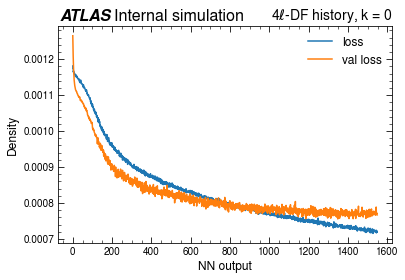

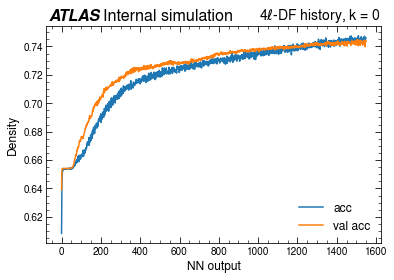

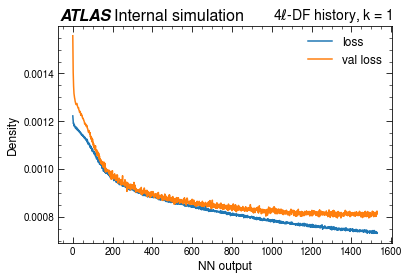

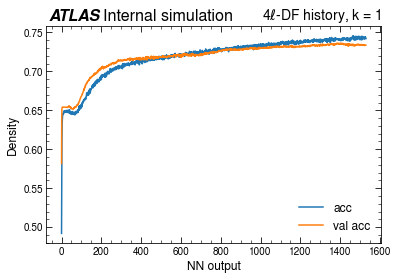

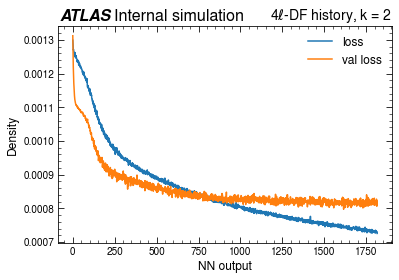

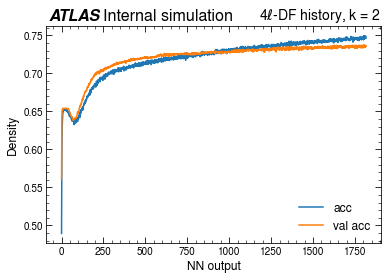

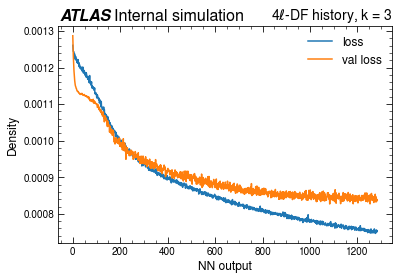

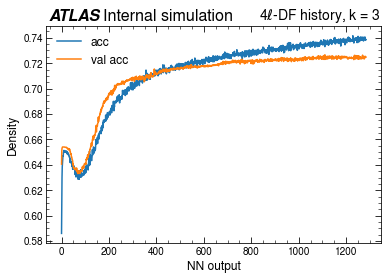

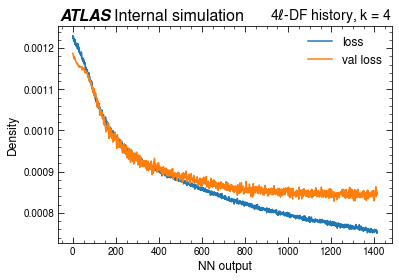

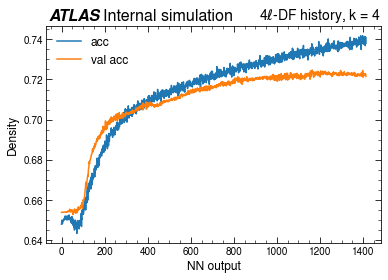

In [54]:
# Generate training history plots
for k in range(K_FOLDS):
    # Load model
    model_dir = 'models/SR_DF/'
    plot_dir = 'plots/SR_DF/'
    model_name = 'classifier_abs_wgt_k_' + str(k)
    
    with open(model_dir + model_name + '_history.pkl', 'rb') as f:
        history = pickle.load(f)
        
    # Loss
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val loss')
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('4$\ell$-DF history, k = ' + str(k), fontsize=14, loc='right')
    
    save_fig(plot_dir, model_name + '_loss')
    plt.show()
    
    # Accuracy
    plt.plot(history['accuracy'], label='acc')
    plt.plot(history['val_accuracy'], label='val acc')
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('4$\ell$-DF history, k = ' + str(k), fontsize=14, loc='right')
    
    save_fig(plot_dir, model_name + '_acc')
    plt.show()

In [55]:
nn_out_col = 'nn_out'

combined_data[nn_out_col] = -1

for k in range(K_FOLDS):
    # Load model
    model_dir = 'models/SR_DF/'
    model_name = 'classifier_abs_wgt_k_' + str(k)
    
    K.clear_session()
    classifier = keras.models.load_model(model_dir + model_name)
    
    # We test classifier k on slice k
    x_test = combined_data[combined_data.k_fold == k][train_feats]
    combined_data.loc[combined_data.k_fold == k, nn_out_col] = classifier.predict(x_test, batch_size=10000)

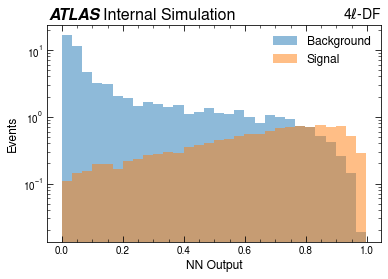

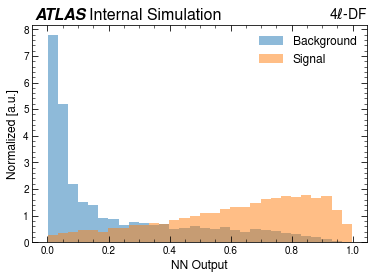

In [99]:
bg_sample = combined_data[combined_data.is_signal == 0]
sig_sample = combined_data[combined_data.is_signal == 1]


plot_util.make_nn_output_plot(bg_sample, sig_sample, 'nn_out', 'Background', 'Signal', 
                              save=True, save_dir='plots/SR_DF/', save_name='nn_output', 
                              title='4$\ell$-DF', log=True)
plot_util.make_nn_output_plot(bg_sample, sig_sample, 'nn_out', 'Background', 'Signal', density=True, 
                              save=True, save_dir='plots/SR_DF/', save_name='nn_output_density', 
                              title='4$\ell$-DF', log=False)

In [129]:
n_cuts = 100

cuts = np.arange(0, 1, 1./n_cuts)
sigs = [-1]*n_cuts

max_sig = -1
max_sig_loc = -1

for i, nn_cut in enumerate(cuts):
    bg_sample = combined_data[(combined_data.is_signal == 0)&(combined_data.nn_out >= nn_cut)]
    sig_sample = combined_data[(combined_data.is_signal == 1)&(combined_data.nn_out >= nn_cut)]

    n_sig = sum(sig_sample.wgt)
    n_bg = sum(bg_sample.wgt)

    sig = util.significance(n_sig, n_bg)
    sigs[i] = sig
    if sig > max_sig:
        max_sig = sig
        max_sig_loc = nn_cut

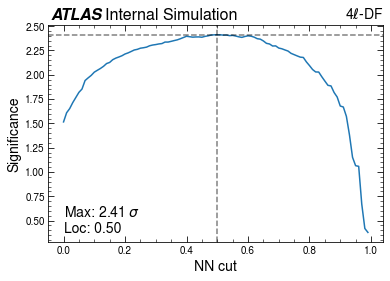

In [130]:
# Plot scan
plt.figure(figsize=(6, 4))
plt.plot(cuts, sigs)

plt.axhline(y=max_sig, color='black', ls='--', alpha=0.5)
plt.axvline(x=max_sig_loc, color='black', ls='--', alpha=0.5)

plt.ylabel('Significance', fontsize=14)
plt.xlabel('NN cut', fontsize=14)
plt.title('4$\ell$-DF', loc='right', fontsize=14)

plt.text(min(cuts), min(sigs), 
         'Max: %.2f $\sigma$\nLoc: %.2f'%(max_sig, max_sig_loc),
         fontsize=14)

atlasify('Internal Simulation', outside=True)

plot_util.save_fig('plots/SR_DF/', 'sig_scan')